In [1]:
import math
import json
import os
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.fft
# from torchinfo import summary
from torch.utils.data import TensorDataset, DataLoader
# import tensorflow as tf
from tqdm import tqdm
from matplotlib import rc
from pylab import rcParams
plt.style.use('fivethirtyeight')
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [1]:
# %matplotlib inline
# %config InlineBackend. figure_format='retina'
# sns.set(style='darkgrid', palette='muted', font_scale=1.2, rc={"axes.facecolor": "#2E2E2E", "axes.grid": True, "grid.color": "#333333", "axes.edgecolor": "#424242"})
# color_pal = ['#FF6E40', '#FFEA00', '#1DE9B6', '#00E5FF', '#D500F9']
# sns.set_palette(sns.color_palette(color_pal))
# rcParams['figure.figsize' ] = 14, 7
# rcParams['text.color'] = 'black'       # Titles and text
# rcParams['axes.labelcolor'] = 'white'  # Axis labels
# rcParams['xtick.color'] = 'black'      # X-axis tick labels
# rcParams['ytick.color'] = 'black'
# tqdm. pandas ()
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import seaborn as sns
from matplotlib import rcParams
from tqdm import tqdm

# Light theme settings
sns.set(style='whitegrid', palette='muted', font_scale=1.2, 
        rc={
            "axes.facecolor": "#FAFAFA",   # Light grey background
            "axes.grid": True,
            "grid.color": "#DDDDDD",       # Light grid lines
            "axes.edgecolor": "#CCCCCC"    # Light axis edges
        })

# Light pastel color palette
color_pal = ["#FF3C00", "#0059FF", "#00FF0D", "#D900FF", "#C09300",]
sns.set_palette(sns.color_palette(color_pal))

# Set figure size and text colors appropriate for light background
rcParams['figure.figsize'] = (14, 7)
rcParams['text.color'] = 'black'       # Titles and text
rcParams['axes.labelcolor'] = 'black'  # Axis labels
rcParams['xtick.color'] = 'black'      # X-axis tick labels
rcParams['ytick.color'] = 'black'      # Y-axis tick labels

# Enable tqdm pandas integration
tqdm.pandas()


In [2]:
train_df_scaled = pd.read_csv("Alibaba_random_500/train.csv")
val_df_scaled = pd.read_csv("Alibaba_random_500/val.csv")
test_df_scaled = pd.read_csv("Alibaba_random_500/test.csv") 

In [3]:
train_df_scaled.shape, val_df_scaled.shape, test_df_scaled.shape # 1999990

((16043024, 13), (3437791, 13), (3437792, 13))

In [8]:
train_df_scaled=train_df_scaled[-(int)(len(train_df_scaled)/5):]
val_df_scaled=val_df_scaled[:(int)(len(test_df_scaled)/5)]
test_df_scaled=test_df_scaled[:(int)(len(test_df_scaled)/5)]
train_df_scaled.shape, val_df_scaled.shape, test_df_scaled.shape

((641720, 13), (137511, 13), (137511, 13))

In [9]:
train_df_scaled.columns

Index(['hour', 'minute', 'second', 'day', 'weekday', 'mem_util_percent',
       'mem_gps', 'mkpi', 'net_in', 'net_out', 'disk_io_percent',
       'cpu_difference', 'cpu_util_percent'],
      dtype='object')

In [10]:
timesteps = 59 # Define timesteps: for nxn window choose 2n-1 
columns_to_scale = ['hour', 'minute', 'second', 'day', 'weekday', 'mem_util_percent',
       'mem_gps', 'mkpi', 'net_in', 'net_out', 'disk_io_percent',
       'cpu_difference', 'cpu_util_percent']

forecast_horizon = 1  # Number of future steps to predict

def create_sequences(data, timesteps, target_idx, horizon):
    X, y = [], []
    for i in tqdm(range(timesteps, len(data) - horizon + 1)):
        X.append(data[i - timesteps:i])
        y.append(data[i:i + horizon, target_idx])  # Get next 30 values
    return np.array(X), np.array(y)

cpu_data = train_df_scaled[columns_to_scale].values  # Extract 'cpu_usage' for sequence creation
X_train, y_train = create_sequences(cpu_data, timesteps, -1, forecast_horizon)  # Create sequences

cpu_data = val_df_scaled[columns_to_scale].values  # Extract 'cpu_usage' for sequence creation
X_val, y_val = create_sequences(cpu_data, timesteps, -1, forecast_horizon)  # Create sequences

cpu_data = test_df_scaled[columns_to_scale].values  # Extract 'cpu_usage' for sequence creation
X_test, y_test = create_sequences(cpu_data, timesteps, -1, forecast_horizon)  # Create sequences


100%|██████████| 137452/137452 [00:00<00:00, 2066971.20it/s]


In [11]:
features = X_train.shape[2]
features

13

In [12]:
def visualize_target_sequence(X, y_true, y_pred=None, sample_idx=0, feature_idx=-1):
    """
    Visualizes the input sequence and forecast horizon for a selected sample.

    Args:
        X (np.ndarray): Input sequences of shape (samples, timesteps, features).
        y_true (np.ndarray): Ground truth targets of shape (samples, horizon).
        y_pred (np.ndarray, optional): Predicted targets of shape (samples, horizon). Default is None.
        sample_idx (int): Index of the sample to visualize.
        feature_idx (int): Index of the feature to plot from X (default: last feature).
    """
    input_sequence = X[sample_idx, :, feature_idx]
    future_targets = y_true[sample_idx]
    
    plt.figure(figsize=(12, 5))
    plt.plot(range(len(input_sequence)), input_sequence, label='Input: cpu_difference (past)')
    plt.plot(range(len(input_sequence), len(input_sequence) + len(future_targets)),
             future_targets, label='Target: cpu_difference (future)', linestyle='--')

    if y_pred is not None:
        future_preds = y_pred[sample_idx]
        plt.plot(range(len(input_sequence), len(input_sequence) + len(future_preds)),
                 future_preds, label='Prediction: cpu_difference', linestyle='-.', color='red')

    plt.axvline(x=len(input_sequence)-1, color='gray', linestyle=':', label='Prediction Start')
    plt.xlabel('Timestep')
    plt.ylabel('cpu_difference')
    plt.title(f'cpu_difference Forecast (Sample #{sample_idx})')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [13]:
# Prepare Data (Example: replace with actual dataset)
X_train = torch.tensor(X_train, dtype=torch.float32).clone().detach()
y_train = torch.tensor(y_train, dtype=torch.float32).clone().detach()
X_val = torch.tensor(X_val, dtype=torch.float32).clone().detach()
y_val = torch.tensor(y_val, dtype=torch.float32).clone().detach()
X_test = torch.tensor(X_test, dtype=torch.float32).clone().detach()
y_test = torch.tensor(y_test, dtype=torch.float32).clone().detach()

print(X_train.shape, y_train.shape)  # Should be (1000, timesteps, features) and (1000, 1)

train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, drop_last=True)
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, drop_last=True)  # No shuffling for test data
val_dataset = TensorDataset(X_val, y_val)
val_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, drop_last=True)  # No shuffling for test data

torch.Size([641661, 59, 13]) torch.Size([641661, 1])


In [14]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


#### helpers

In [15]:
def save_checkpoint(model, optimizer, epoch, loss, path):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss
    }
    torch.save(checkpoint, path)
    print(f"Checkpoint saved at epoch {epoch+1}")

In [16]:
# Function to load checkpoint
def load_checkpoint(model, optimizer, path):
    if os.path.exists(path):
        checkpoint = torch.load(path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch'] + 1  # Resume from the next epoch
        print(f"Checkpoint loaded: Resuming from epoch {start_epoch}")
        return start_epoch
    return 0  # If no checkpoint, start from epoch 0

In [17]:
# Function to compute validation loss
def evaluate_model_trianing(model, val_loader, loss_fn):
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    with torch.no_grad():  # No need to track gradients during validation
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            # y_batch = y_batch.view(-1, 1)
            loss = loss_fn(y_pred, y_batch)
            val_loss += loss.item()
    return val_loss / len(val_loader)

In [18]:
def train_model(model, train_loader, val_loader, optimizer, loss_fn, epochs=10, checkpoint_interval=2, patience=5, path="checkpoints"):
    start_epoch = load_checkpoint(model, optimizer, path)
    model.train()
    print("#### TRAINING STARTED ####")

    best_val_loss = float('inf')
    patience_counter = 0
    train_losses = []
    val_losses = []

    start_time = time.time()

    for epoch in range(start_epoch, epochs):
        model.train()
        running_train_loss = 0.0

        for X_batch, y_batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()

        avg_train_loss = running_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        val_loss = evaluate_model_trianing(model, val_loader, loss_fn)
        val_losses.append(val_loss)

        print(f"Epoch {epoch+1:02d} | Train Loss: {avg_train_loss:.4f} | Val Loss: {val_loss:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            save_checkpoint(model, optimizer, epoch, val_loss, path)
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"⚠️ Early stopping at epoch {epoch+1} (no improvement in val loss for {patience} epochs).")
            break

        if (epoch + 1) % checkpoint_interval == 0:
            save_checkpoint(model, optimizer, epoch, val_loss, path)

    # Final stats
    total_time = round(time.time() - start_time, 2)
    print("\n#### TRAINING COMPLETE ####")
    print(f"Total Time Elapsed: {total_time} seconds")
    print(f"Best Validation Loss: {best_val_loss:.4f}")
    print(f"Final Train Loss: {train_losses[-1]:.4f}")
    print(f"Final Val Loss: {val_losses[-1]:.4f}")

    # Plotting Loss Curves
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Train Loss', marker='o')
    plt.plot(val_losses, label='Validation Loss', marker='x')
    plt.title("Loss vs Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [19]:
# Function to load model from checkpoint
def load_model_from_checkpoint(model, checkpoint_path, device="cpu"):
    if os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        print(f"Checkpoint loaded from {checkpoint_path}")
    else:
        print("No checkpoint found! Using randomly initialized model.")
    return model

In [20]:
import torch
import torch.nn as nn
import numpy as np
import time
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tqdm import tqdm

def evaluate_model(model, test_loader, checkpoint_path, device="cpu"):
    model = load_model_from_checkpoint(model, checkpoint_path, device)
    model.to(device)
    model.eval()

    all_predictions = []
    all_targets = []

    total_inference_time = 0.0
    total_samples = 0

    with torch.no_grad():
        for X_batch, y_batch in tqdm(test_loader, desc="Evaluating"):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            start_time = time.perf_counter()
            y_pred = model(X_batch)
            end_time = time.perf_counter()

            total_inference_time += (end_time - start_time)
            total_samples += X_batch.size(0)

            all_predictions.append(y_pred.cpu().numpy())
            all_targets.append(y_batch.cpu().numpy())

    # Convert to NumPy
    predictions_np = np.concatenate(all_predictions, axis=0)
    y_test_np = np.concatenate(all_targets, axis=0)

    # Convert to Torch tensors for loss calculations
    predictions_tensor = torch.tensor(predictions_np, dtype=torch.float32, device=device)
    y_test_tensor = torch.tensor(y_test_np, dtype=torch.float32, device=device)

    if predictions_tensor.shape != y_test_tensor.shape:
        print(f"⚠️ Shape mismatch! Predictions: {predictions_tensor.shape}, Targets: {y_test_tensor.shape}")
        y_test_tensor = y_test_tensor.view_as(predictions_tensor)

    # Calculate metrics
    mae = mean_absolute_error(y_test_np, predictions_np)
    rmse = np.sqrt(mean_squared_error(y_test_np, predictions_np))
    huber_loss = nn.HuberLoss()(predictions_tensor, y_test_tensor).item()
    mse_loss = nn.MSELoss()(predictions_tensor, y_test_tensor).item()
    avg_inference_time = (total_inference_time / total_samples) * 1000  # ms per sample

    # Print metrics
    print("\n##### Evaluation Metrics #####")
    print(f"Test MAE         : {mae:.4f}")
    print(f"Test RMSE        : {rmse:.4f}")
    print(f"Test Huber Loss  : {huber_loss:.4f}")
    print(f"Test MSE Loss    : {mse_loss:.4f}")
    print(f"Avg Inference Time per Sample: {avg_inference_time:.4f} ms")
    print(f"Total Evaluation Time        : {total_inference_time:.2f} seconds")

    return predictions_np

In [21]:
def print_model_summary(model):
    total_params = 0
    print(f"{'Layer':<40} {'Param Shape':<30} {'# Params'}")
    print("-" * 80)

    for name, param in model.named_parameters():
        if param.requires_grad:
            param_count = param.numel()
            total_params += param_count
            print(f"{name:<40} {str(list(param.shape)):<30} {param_count}")

    print("-" * 80)
    print(f"{'Total Trainable Params':<40} {'':<30} {total_params:,}")


#### C LSTM AE

In [41]:
class C_LSTM_AE(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=(1, 5), stride=(1, 1), padding=(0, 2)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(1, 2), stride=(1, 2)),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 32, kernel_size=(1, 5), stride=(1, 1), padding=(0, 2)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(1, 2), stride=(1, 2)),
        )
        self.lstm_encoder = nn.LSTM(input_size=96,hidden_size=64)
        self.lstm_decoder = nn.LSTM(input_size=64, hidden_size=128)
        self.dnn = nn.Sequential(
            nn.Linear(in_features=128, out_features=510),
            nn.ReLU(),
            nn.Linear(in_features=510, out_features=forecast_horizon),
        )
    def forward(self, X):
        X = X.unsqueeze(1)
        X = self.conv1(X) # batch, 1, timesteps, features
        X = self.conv2(X)
        X = X.permute(2, 0, 1, 3).flatten(2)
        H, _ = self.lstm_encoder(X) # timesteps, batch, features*(1+something from cnn)
        _, (h, _) = self.lstm_decoder(H)
        y = self.dnn(h.squeeze(0)) # batch, 128 (last hidden state of lstm)
        return y

In [43]:
model = C_LSTM_AE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
loss_fn = nn.MSELoss()
print_model_summary(model)

Layer                                    Param Shape                    # Params
--------------------------------------------------------------------------------
conv1.0.weight                           [64, 1, 1, 5]                  320
conv1.0.bias                             [64]                           64
conv2.0.weight                           [32, 64, 1, 5]                 10240
conv2.0.bias                             [32]                           32
lstm_encoder.weight_ih_l0                [256, 96]                      24576
lstm_encoder.weight_hh_l0                [256, 64]                      16384
lstm_encoder.bias_ih_l0                  [256]                          256
lstm_encoder.bias_hh_l0                  [256]                          256
lstm_decoder.weight_ih_l0                [512, 64]                      32768
lstm_decoder.weight_hh_l0                [512, 128]                     65536
lstm_decoder.bias_ih_l0                  [512]                        

In [44]:
checkpoint_path = "ck_5/C_LSTM_AE_alibaba.pth"

#### TRAINING STARTED ####


Epoch 1/100: 100%|██████████| 10025/10025 [03:49<00:00, 43.62it/s]


Epoch 01 | Train Loss: 0.0040 | Val Loss: 0.0030
Checkpoint saved at epoch 1


Epoch 2/100: 100%|██████████| 10025/10025 [03:40<00:00, 45.56it/s]


Epoch 02 | Train Loss: 0.0032 | Val Loss: 0.0031
Checkpoint saved at epoch 2


Epoch 3/100: 100%|██████████| 10025/10025 [03:42<00:00, 45.14it/s]


Epoch 03 | Train Loss: 0.0031 | Val Loss: 0.0032


Epoch 4/100: 100%|██████████| 10025/10025 [03:41<00:00, 45.29it/s]


Epoch 04 | Train Loss: 0.0031 | Val Loss: 0.0031
Checkpoint saved at epoch 4


Epoch 5/100: 100%|██████████| 10025/10025 [03:33<00:00, 46.89it/s]


Epoch 05 | Train Loss: 0.0031 | Val Loss: 0.0032


Epoch 6/100: 100%|██████████| 10025/10025 [03:40<00:00, 45.42it/s]


Epoch 06 | Train Loss: 0.0031 | Val Loss: 0.0030
Checkpoint saved at epoch 6
Checkpoint saved at epoch 6


Epoch 7/100: 100%|██████████| 10025/10025 [03:32<00:00, 47.16it/s]


Epoch 07 | Train Loss: 0.0031 | Val Loss: 0.0032


Epoch 8/100: 100%|██████████| 10025/10025 [03:40<00:00, 45.51it/s]


Epoch 08 | Train Loss: 0.0031 | Val Loss: 0.0030
Checkpoint saved at epoch 8
Checkpoint saved at epoch 8


Epoch 9/100: 100%|██████████| 10025/10025 [03:32<00:00, 47.26it/s]


Epoch 09 | Train Loss: 0.0031 | Val Loss: 0.0032


Epoch 10/100: 100%|██████████| 10025/10025 [03:41<00:00, 45.33it/s]


Epoch 10 | Train Loss: 0.0031 | Val Loss: 0.0030
Checkpoint saved at epoch 10


Epoch 11/100: 100%|██████████| 10025/10025 [03:32<00:00, 47.24it/s]


Epoch 11 | Train Loss: 0.0031 | Val Loss: 0.0030


Epoch 12/100: 100%|██████████| 10025/10025 [03:41<00:00, 45.35it/s]


Epoch 12 | Train Loss: 0.0031 | Val Loss: 0.0033
Checkpoint saved at epoch 12


Epoch 13/100: 100%|██████████| 10025/10025 [03:33<00:00, 47.00it/s]


Epoch 13 | Train Loss: 0.0030 | Val Loss: 0.0031


Epoch 14/100: 100%|██████████| 10025/10025 [03:41<00:00, 45.31it/s]


Epoch 14 | Train Loss: 0.0030 | Val Loss: 0.0031
Checkpoint saved at epoch 14


Epoch 15/100: 100%|██████████| 10025/10025 [03:39<00:00, 45.76it/s]


Epoch 15 | Train Loss: 0.0030 | Val Loss: 0.0030


Epoch 16/100: 100%|██████████| 10025/10025 [03:41<00:00, 45.20it/s]


Epoch 16 | Train Loss: 0.0030 | Val Loss: 0.0030
Checkpoint saved at epoch 16
Checkpoint saved at epoch 16


Epoch 17/100: 100%|██████████| 10025/10025 [03:42<00:00, 45.15it/s]


Epoch 17 | Train Loss: 0.0030 | Val Loss: 0.0030
Checkpoint saved at epoch 17


Epoch 18/100: 100%|██████████| 10025/10025 [03:33<00:00, 46.94it/s]


Epoch 18 | Train Loss: 0.0030 | Val Loss: 0.0030
Checkpoint saved at epoch 18


Epoch 19/100: 100%|██████████| 10025/10025 [03:40<00:00, 45.39it/s]


Epoch 19 | Train Loss: 0.0030 | Val Loss: 0.0032


Epoch 20/100: 100%|██████████| 10025/10025 [03:31<00:00, 47.35it/s]


Epoch 20 | Train Loss: 0.0030 | Val Loss: 0.0030
Checkpoint saved at epoch 20
Checkpoint saved at epoch 20


Epoch 21/100: 100%|██████████| 10025/10025 [03:40<00:00, 45.39it/s]


Epoch 21 | Train Loss: 0.0030 | Val Loss: 0.0030
Checkpoint saved at epoch 21


Epoch 22/100: 100%|██████████| 10025/10025 [03:31<00:00, 47.34it/s]


Epoch 22 | Train Loss: 0.0030 | Val Loss: 0.0030
Checkpoint saved at epoch 22


Epoch 23/100: 100%|██████████| 10025/10025 [03:41<00:00, 45.27it/s]


Epoch 23 | Train Loss: 0.0030 | Val Loss: 0.0032


Epoch 24/100: 100%|██████████| 10025/10025 [03:31<00:00, 47.48it/s]


Epoch 24 | Train Loss: 0.0030 | Val Loss: 0.0030
Checkpoint saved at epoch 24


Epoch 25/100: 100%|██████████| 10025/10025 [03:41<00:00, 45.17it/s]


Epoch 25 | Train Loss: 0.0030 | Val Loss: 0.0030


Epoch 26/100: 100%|██████████| 10025/10025 [03:31<00:00, 47.47it/s]


Epoch 26 | Train Loss: 0.0030 | Val Loss: 0.0030
Checkpoint saved at epoch 26


Epoch 27/100: 100%|██████████| 10025/10025 [03:40<00:00, 45.53it/s]


Epoch 27 | Train Loss: 0.0030 | Val Loss: 0.0030


Epoch 28/100: 100%|██████████| 10025/10025 [03:37<00:00, 46.18it/s]


Epoch 28 | Train Loss: 0.0030 | Val Loss: 0.0030
Checkpoint saved at epoch 28


Epoch 29/100: 100%|██████████| 10025/10025 [03:41<00:00, 45.36it/s]


Epoch 29 | Train Loss: 0.0030 | Val Loss: 0.0031


Epoch 30/100: 100%|██████████| 10025/10025 [03:41<00:00, 45.34it/s]


Epoch 30 | Train Loss: 0.0030 | Val Loss: 0.0030
Checkpoint saved at epoch 30


Epoch 31/100: 100%|██████████| 10025/10025 [03:33<00:00, 46.88it/s]


Epoch 31 | Train Loss: 0.0030 | Val Loss: 0.0031
⚠️ Early stopping at epoch 31 (no improvement in val loss for 10 epochs).

#### TRAINING COMPLETE ####
Total Time Elapsed: 7480.3 seconds
Best Validation Loss: 0.0030
Final Train Loss: 0.0030
Final Val Loss: 0.0031


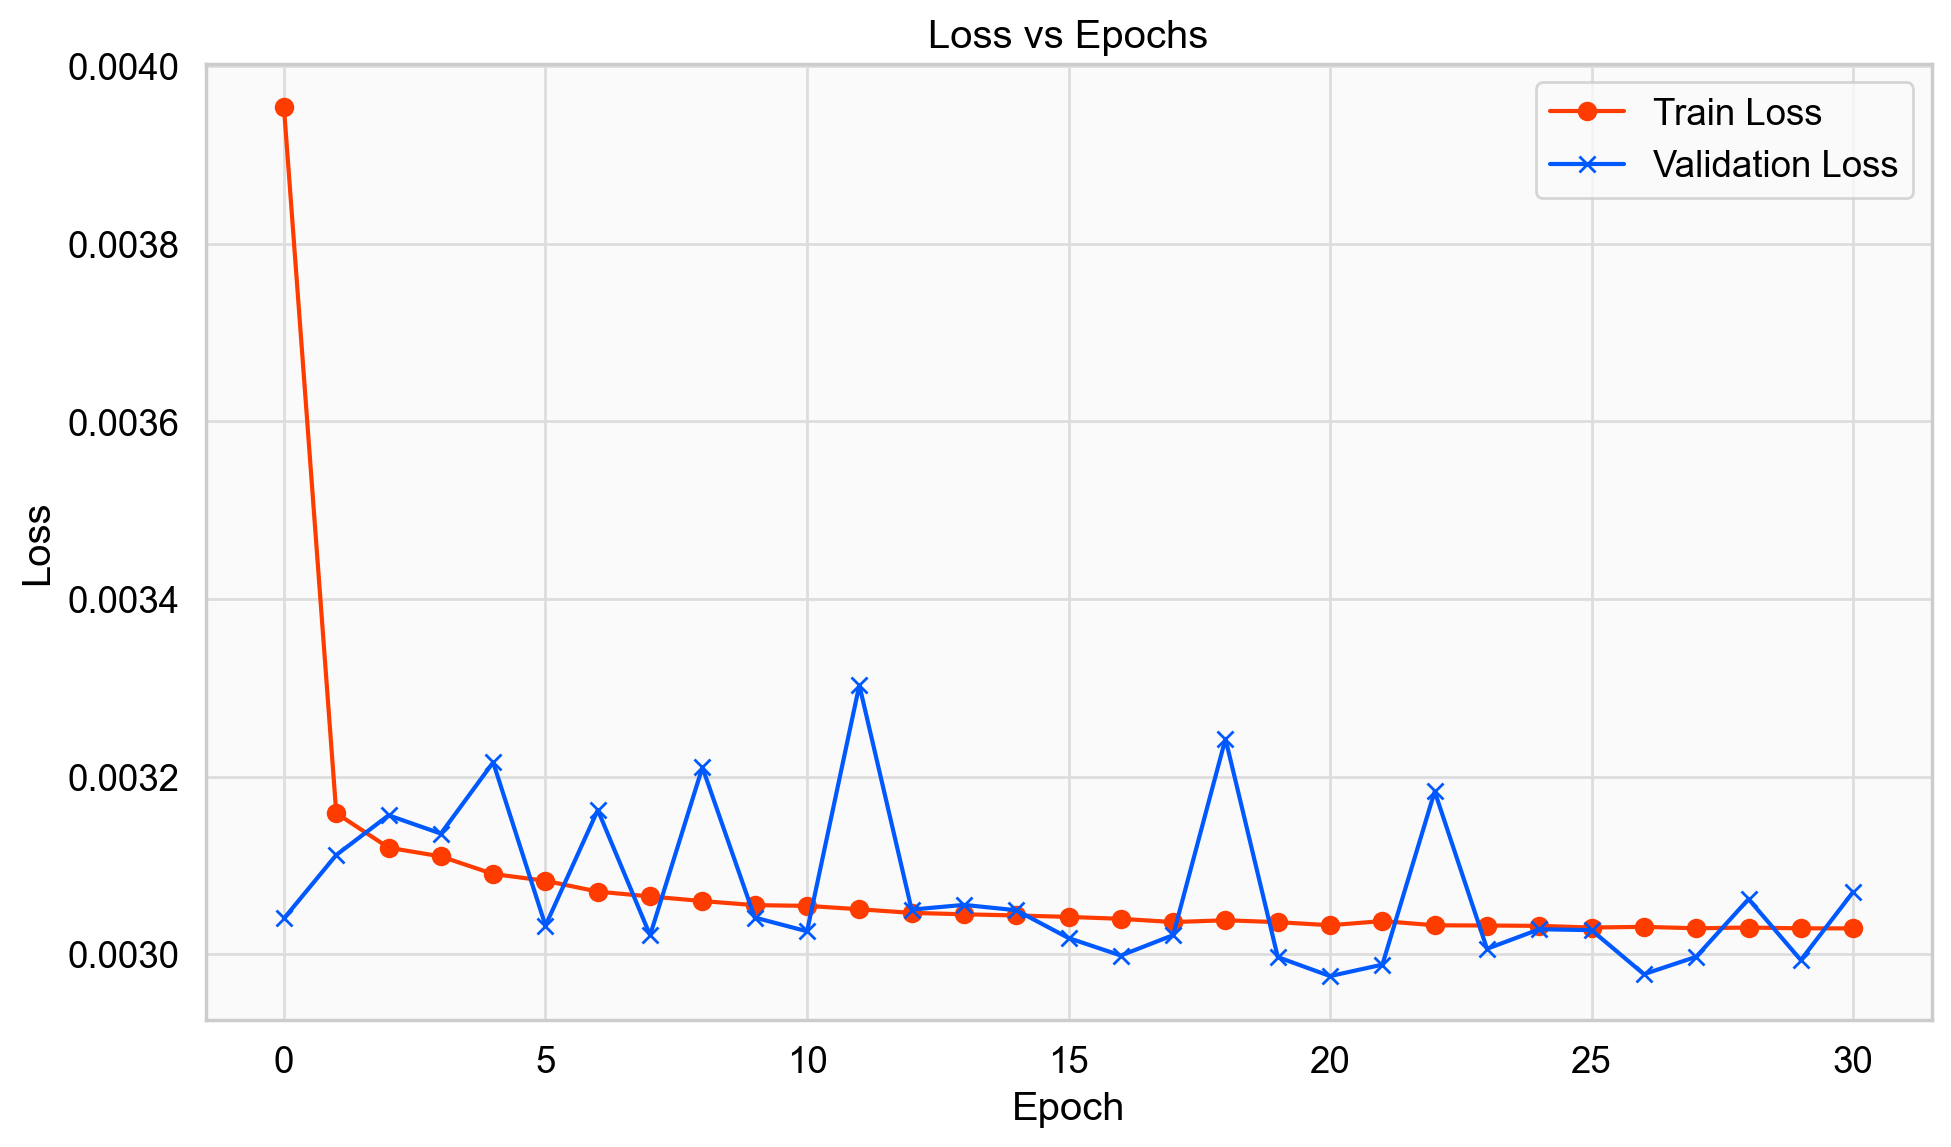

In [83]:
train_model(model, train_loader, val_loader, optimizer, loss_fn, epochs=100, patience=10, path=checkpoint_path)

In [45]:
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()  # Set model to evaluation mode
prediction = evaluate_model(model, test_loader, checkpoint_path, device=device)

C:\Users\User\AppData\Local\Temp\ipykernel_24984\671114600.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


Checkpoint loaded from ck_5/C_LSTM_AE_alibaba.pth


Evaluating: 100%|██████████| 10742/10742 [00:16<00:00, 664.83it/s]



##### Evaluation Metrics #####
Test MAE         : 0.0495
Test RMSE        : 0.0738
Test Huber Loss  : 0.0027
Test MSE Loss    : 0.0055
Avg Inference Time per Sample: 0.0069 ms
Total Evaluation Time        : 4.75 seconds


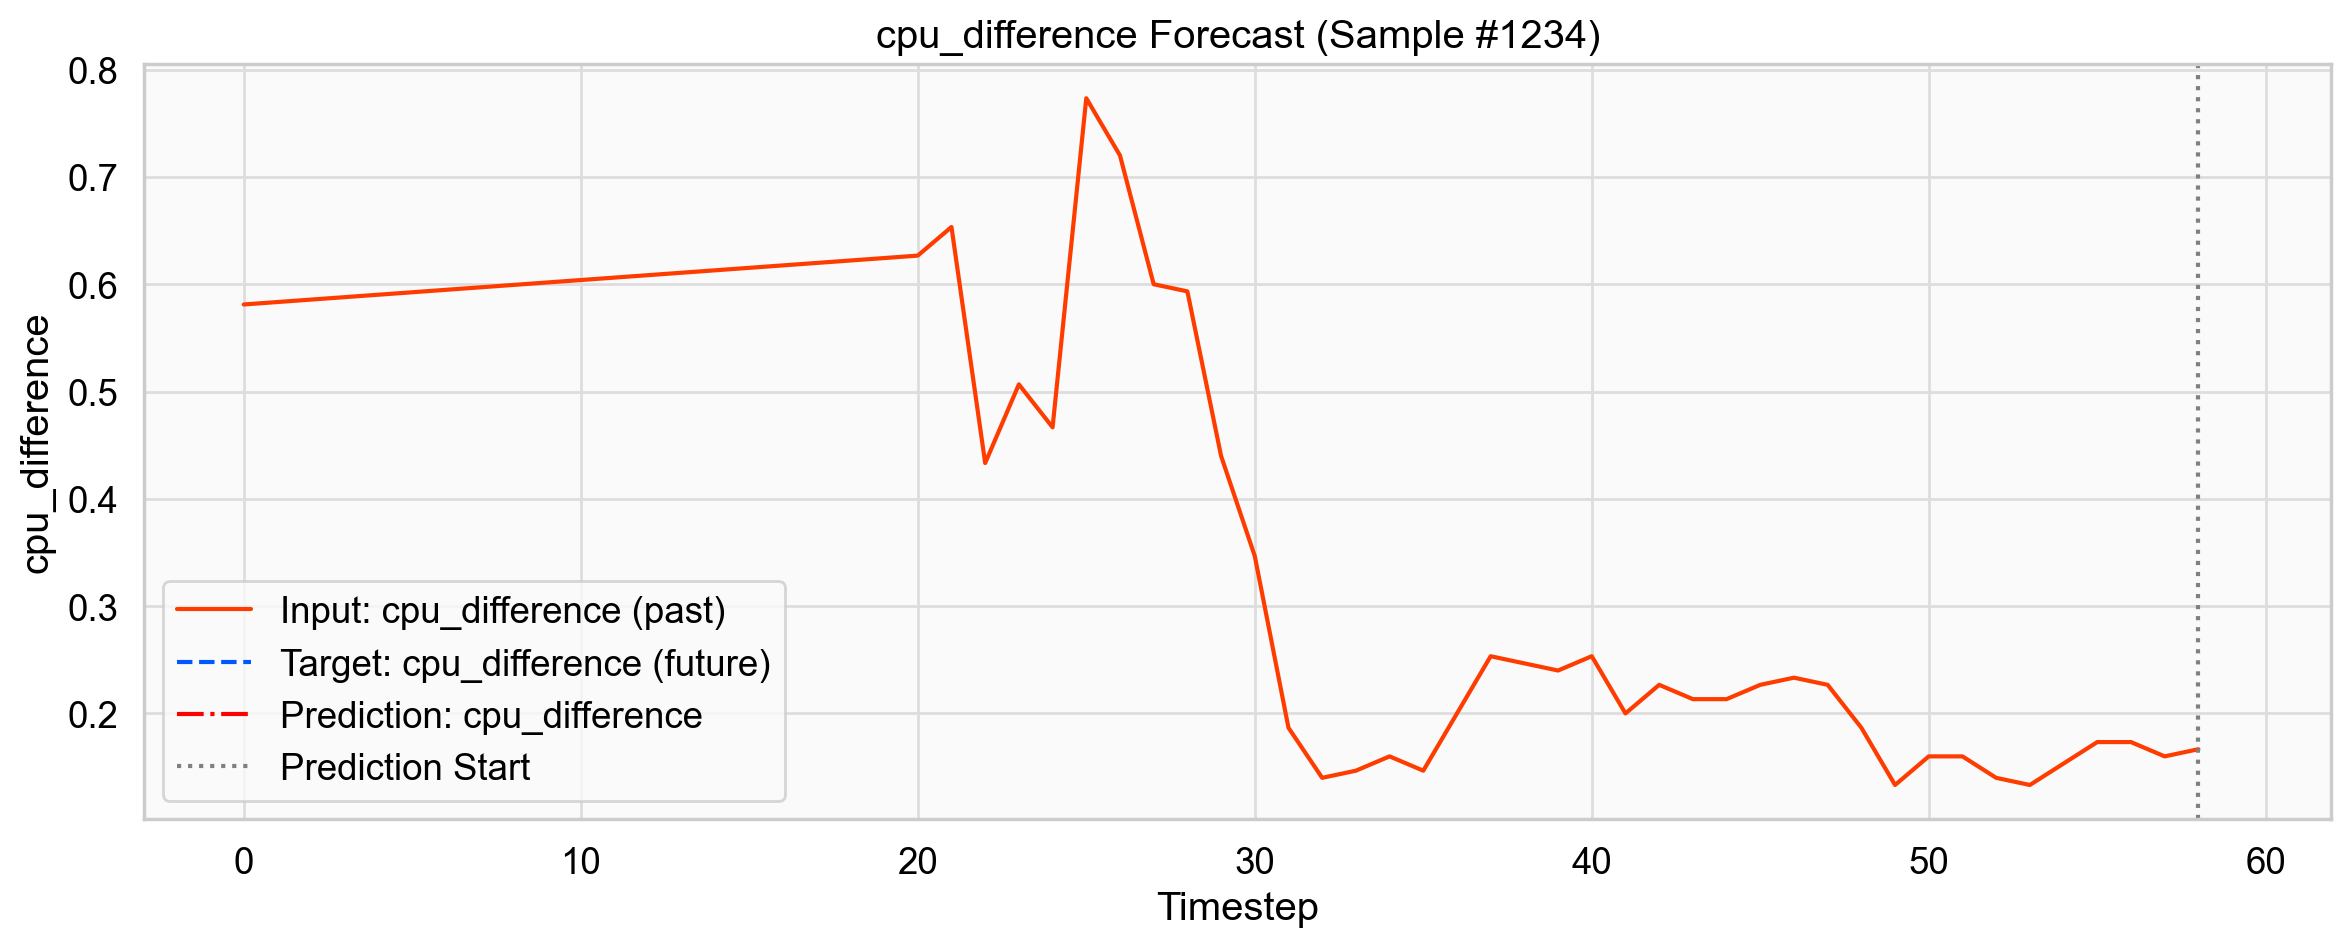

In [85]:
visualize_target_sequence(X_test, y_test, prediction, sample_idx=1234)

In [86]:
# visualize_target_sequence(X_test, prediction, sample_idx = 458)


#### C LSTM

In [46]:
class C_LSTM(nn.Module):
    def __init__(self, features):
        super().__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv1d(features, 64, kernel_size=5, stride=1, padding=2),
            nn.Tanh(),
            nn.MaxPool1d(kernel_size=2, stride=2),
        )
        self.conv2 = nn.Sequential(
            nn.Conv1d(64, 64, kernel_size=5, stride=1, padding=2),
            nn.Tanh(),
            nn.MaxPool1d(kernel_size=2, stride=2),
        )
        self.lstm = nn.LSTM(input_size=64, hidden_size=64)
        self.dnn = nn.Sequential(
            nn.Linear(in_features=64, out_features=32),
            nn.Tanh(),
            nn.Linear(in_features=32, out_features=forecast_horizon),
        )

    def forward(self, X):
        # X = X.unsqueeze(1)
        X = X.permute(0, 2, 1)  # Change (batch, seq_len, features) -> (batch, features, seq_len)
        X = self.conv1(X)
        X = self.conv2(X)
        X = X.permute(2, 0, 1)
        _, (h, _) = self.lstm(X)
        y = self.dnn(h.squeeze(0))
        return y

In [47]:
model = C_LSTM(features).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
loss_fn = nn.MSELoss()

print_model_summary(model)

Layer                                    Param Shape                    # Params
--------------------------------------------------------------------------------
conv1.0.weight                           [64, 13, 5]                    4160
conv1.0.bias                             [64]                           64
conv2.0.weight                           [64, 64, 5]                    20480
conv2.0.bias                             [64]                           64
lstm.weight_ih_l0                        [256, 64]                      16384
lstm.weight_hh_l0                        [256, 64]                      16384
lstm.bias_ih_l0                          [256]                          256
lstm.bias_hh_l0                          [256]                          256
dnn.0.weight                             [32, 64]                       2048
dnn.0.bias                               [32]                           32
dnn.2.weight                             [5, 32]                        1

In [48]:
checkpoint_path = "ck_5/C_LSTM_alibaba.pth"

#### TRAINING STARTED ####


Epoch 1/100: 100%|██████████| 10025/10025 [02:16<00:00, 73.32it/s]


Epoch 01 | Train Loss: 0.0046 | Val Loss: 0.0033
Checkpoint saved at epoch 1


Epoch 2/100: 100%|██████████| 10025/10025 [02:15<00:00, 73.99it/s]


Epoch 02 | Train Loss: 0.0036 | Val Loss: 0.0037
Checkpoint saved at epoch 2


Epoch 3/100: 100%|██████████| 10025/10025 [02:16<00:00, 73.49it/s]


Epoch 03 | Train Loss: 0.0035 | Val Loss: 0.0039


Epoch 4/100: 100%|██████████| 10025/10025 [02:16<00:00, 73.55it/s]


Epoch 04 | Train Loss: 0.0035 | Val Loss: 0.0034
Checkpoint saved at epoch 4


Epoch 5/100: 100%|██████████| 10025/10025 [02:15<00:00, 73.81it/s]


Epoch 05 | Train Loss: 0.0035 | Val Loss: 0.0036


Epoch 6/100: 100%|██████████| 10025/10025 [02:16<00:00, 73.32it/s]


Epoch 06 | Train Loss: 0.0034 | Val Loss: 0.0035
Checkpoint saved at epoch 6


Epoch 7/100: 100%|██████████| 10025/10025 [02:16<00:00, 73.42it/s]


Epoch 07 | Train Loss: 0.0034 | Val Loss: 0.0033
Checkpoint saved at epoch 7


Epoch 8/100: 100%|██████████| 10025/10025 [02:15<00:00, 73.73it/s]


Epoch 08 | Train Loss: 0.0034 | Val Loss: 0.0037
Checkpoint saved at epoch 8


Epoch 9/100: 100%|██████████| 10025/10025 [02:16<00:00, 73.41it/s]


Epoch 09 | Train Loss: 0.0034 | Val Loss: 0.0032
Checkpoint saved at epoch 9


Epoch 10/100: 100%|██████████| 10025/10025 [02:15<00:00, 73.72it/s]


Epoch 10 | Train Loss: 0.0034 | Val Loss: 0.0034
Checkpoint saved at epoch 10


Epoch 11/100: 100%|██████████| 10025/10025 [02:16<00:00, 73.28it/s]


Epoch 11 | Train Loss: 0.0034 | Val Loss: 0.0032


Epoch 12/100: 100%|██████████| 10025/10025 [02:17<00:00, 73.06it/s]


Epoch 12 | Train Loss: 0.0034 | Val Loss: 0.0033
Checkpoint saved at epoch 12


Epoch 13/100: 100%|██████████| 10025/10025 [02:16<00:00, 73.69it/s]


Epoch 13 | Train Loss: 0.0034 | Val Loss: 0.0037


Epoch 14/100: 100%|██████████| 10025/10025 [02:16<00:00, 73.41it/s]


Epoch 14 | Train Loss: 0.0034 | Val Loss: 0.0033
Checkpoint saved at epoch 14


Epoch 15/100: 100%|██████████| 10025/10025 [02:16<00:00, 73.24it/s]


Epoch 15 | Train Loss: 0.0034 | Val Loss: 0.0035


Epoch 16/100: 100%|██████████| 10025/10025 [02:16<00:00, 73.54it/s]


Epoch 16 | Train Loss: 0.0034 | Val Loss: 0.0032
Checkpoint saved at epoch 16
Checkpoint saved at epoch 16


Epoch 17/100: 100%|██████████| 10025/10025 [02:17<00:00, 73.17it/s]


Epoch 17 | Train Loss: 0.0034 | Val Loss: 0.0032


Epoch 18/100: 100%|██████████| 10025/10025 [02:16<00:00, 73.47it/s]


Epoch 18 | Train Loss: 0.0034 | Val Loss: 0.0035
Checkpoint saved at epoch 18


Epoch 19/100: 100%|██████████| 10025/10025 [02:16<00:00, 73.39it/s]


Epoch 19 | Train Loss: 0.0034 | Val Loss: 0.0035


Epoch 20/100: 100%|██████████| 10025/10025 [02:16<00:00, 73.38it/s]


Epoch 20 | Train Loss: 0.0034 | Val Loss: 0.0035
Checkpoint saved at epoch 20


Epoch 21/100: 100%|██████████| 10025/10025 [02:16<00:00, 73.26it/s]


Epoch 21 | Train Loss: 0.0034 | Val Loss: 0.0037


Epoch 22/100: 100%|██████████| 10025/10025 [02:16<00:00, 73.50it/s]


Epoch 22 | Train Loss: 0.0034 | Val Loss: 0.0032
Checkpoint saved at epoch 22
Checkpoint saved at epoch 22


Epoch 23/100: 100%|██████████| 10025/10025 [02:16<00:00, 73.21it/s]


Epoch 23 | Train Loss: 0.0034 | Val Loss: 0.0034


Epoch 24/100: 100%|██████████| 10025/10025 [02:16<00:00, 73.30it/s]


Epoch 24 | Train Loss: 0.0034 | Val Loss: 0.0040
Checkpoint saved at epoch 24


Epoch 25/100: 100%|██████████| 10025/10025 [02:16<00:00, 73.63it/s]


Epoch 25 | Train Loss: 0.0034 | Val Loss: 0.0033


Epoch 26/100: 100%|██████████| 10025/10025 [02:17<00:00, 73.09it/s]


Epoch 26 | Train Loss: 0.0034 | Val Loss: 0.0039
Checkpoint saved at epoch 26


Epoch 27/100: 100%|██████████| 10025/10025 [02:16<00:00, 73.26it/s]


Epoch 27 | Train Loss: 0.0034 | Val Loss: 0.0036


Epoch 28/100: 100%|██████████| 10025/10025 [02:16<00:00, 73.27it/s]


Epoch 28 | Train Loss: 0.0034 | Val Loss: 0.0035
Checkpoint saved at epoch 28


Epoch 29/100: 100%|██████████| 10025/10025 [02:16<00:00, 73.63it/s]


Epoch 29 | Train Loss: 0.0034 | Val Loss: 0.0033


Epoch 30/100: 100%|██████████| 10025/10025 [02:16<00:00, 73.33it/s]


Epoch 30 | Train Loss: 0.0034 | Val Loss: 0.0034
Checkpoint saved at epoch 30


Epoch 31/100: 100%|██████████| 10025/10025 [02:16<00:00, 73.36it/s]


Epoch 31 | Train Loss: 0.0034 | Val Loss: 0.0035


Epoch 32/100: 100%|██████████| 10025/10025 [02:16<00:00, 73.22it/s]


Epoch 32 | Train Loss: 0.0034 | Val Loss: 0.0034
⚠️ Early stopping at epoch 32 (no improvement in val loss for 10 epochs).

#### TRAINING COMPLETE ####
Total Time Elapsed: 4986.67 seconds
Best Validation Loss: 0.0032
Final Train Loss: 0.0034
Final Val Loss: 0.0034


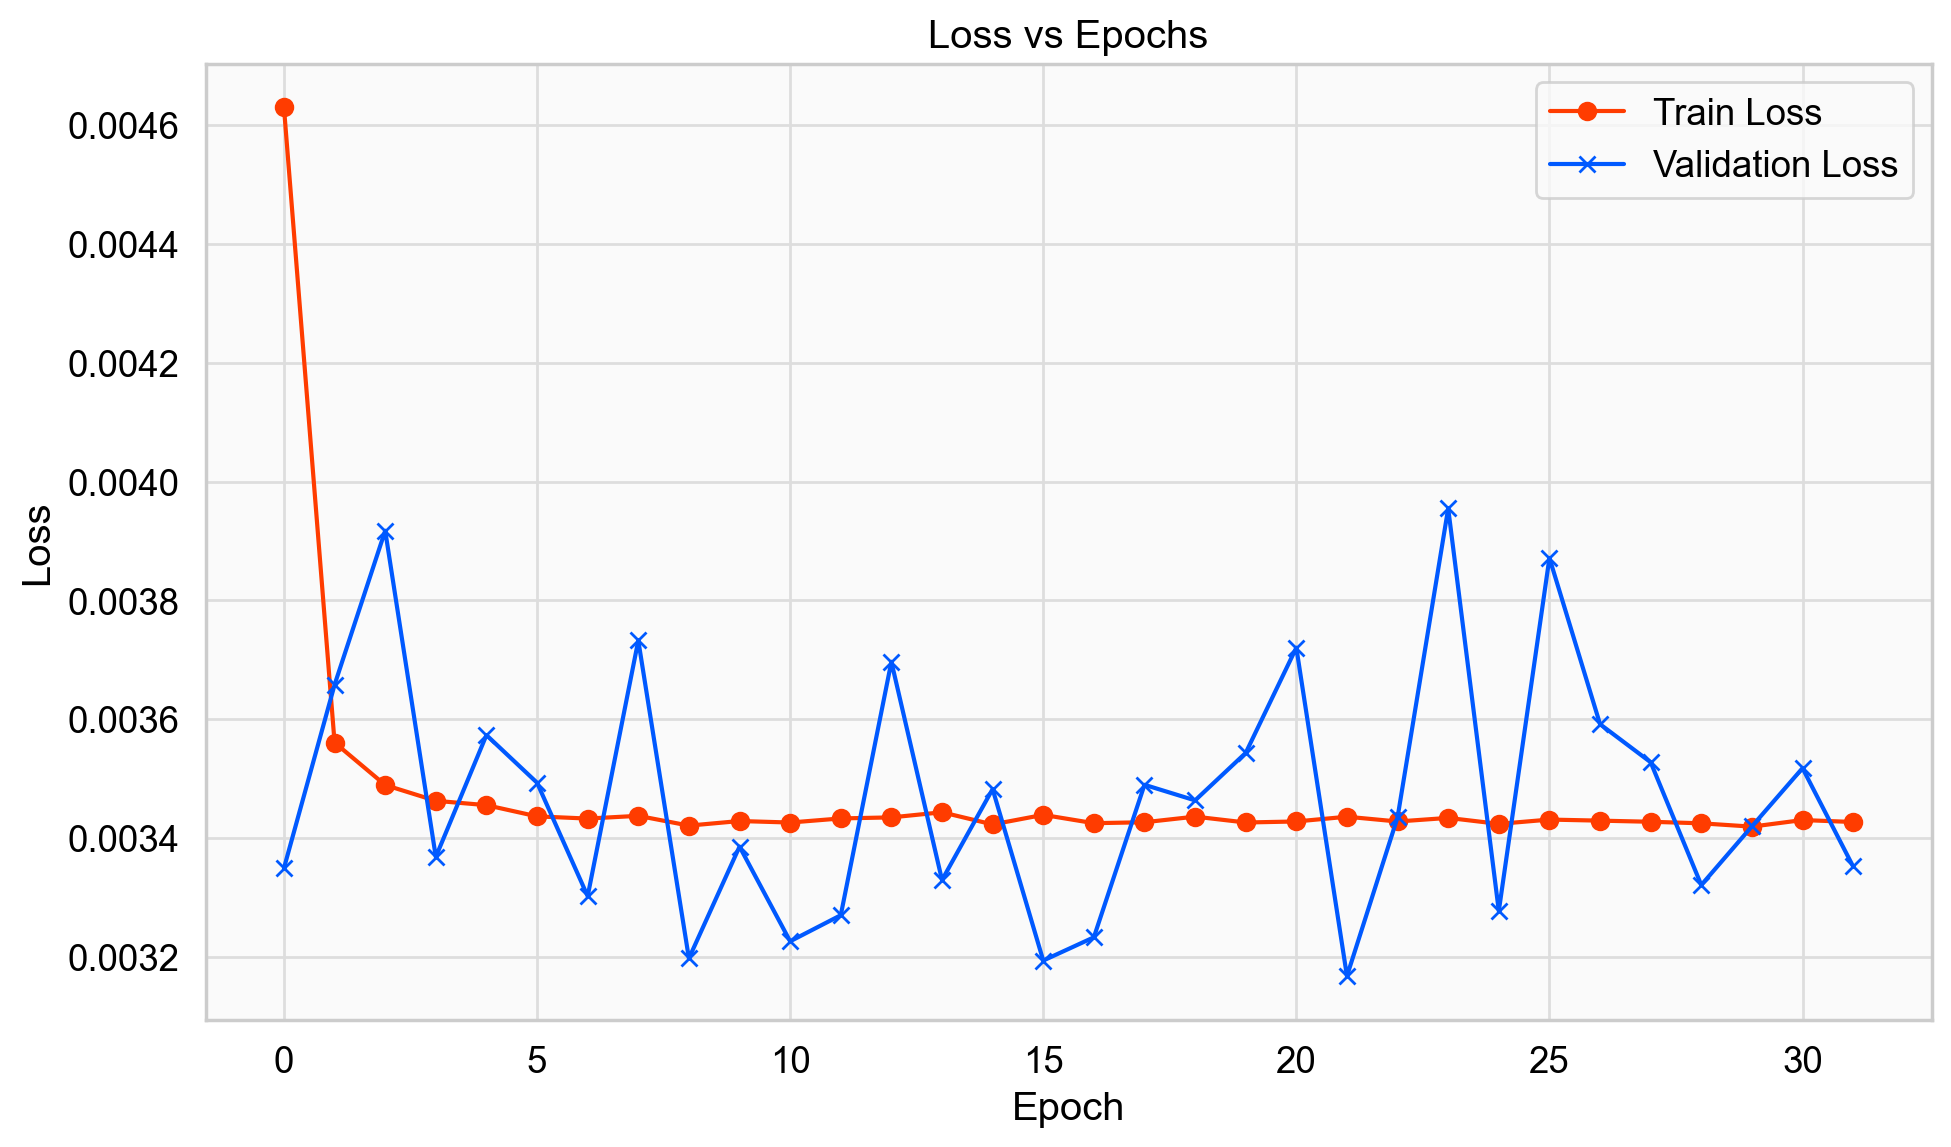

In [90]:
train_model(model, train_loader, val_loader, optimizer, loss_fn, epochs=100, patience=10, path=checkpoint_path)

In [49]:
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()  # Set model to evaluation mode

C:\Users\User\AppData\Local\Temp\ipykernel_24984\1956403801.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)

C_LSTM(
  (conv1): Sequential(
    (0): Conv1d(13, 64, kernel_size=(5,), stride=(1,), padding=(2,))
    (1): Tanh()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv1d(64, 64, kernel_size=(5,), stride=(1,), padding=(2,))
    (1): Tanh()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (lstm): LSTM(64, 64)
  (dnn): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): Tanh()
    (2): Linear(in_features=32, out_features=5, bias=True)
  )
)

In [50]:
evaluate_model(model, test_loader, checkpoint_path, device=device)

C:\Users\User\AppData\Local\Temp\ipykernel_24984\1770941795.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)

Checkpoint loaded from ck_5/C_LSTM_alibaba.pth


Evaluating: 100%|██████████| 10742/10742 [00:11<00:00, 955.02it/s] 



##### Evaluation Metrics #####
Test MAE         : 0.0539
Test RMSE        : 0.0758
Test Huber Loss  : 0.0029
Test MSE Loss    : 0.0057
Avg Inference Time per Sample: 0.0054 ms
Total Evaluation Time        : 3.74 seconds


array([[0.09739955, 0.1036674 , 0.08788009, 0.08992904, 0.08746752],
       [0.12436487, 0.10796059, 0.10441057, 0.10985303, 0.11055271],
       [0.10164759, 0.09770718, 0.09784774, 0.10999741, 0.08870746],
       ...,
       [0.26487643, 0.26013708, 0.26676768, 0.275609  , 0.2845176 ],
       [0.21596986, 0.23288764, 0.2460359 , 0.26355165, 0.25238764],
       [0.22084883, 0.238179  , 0.2575049 , 0.2548785 , 0.2547368 ]],
      dtype=float32)

#### CNN 1D

In [51]:
class CNN_1D(nn.Module):
    def __init__(self, seq_length=59, features=9):  # 9 features as channels
        super().__init__()

        self.block1 = nn.Sequential(
            nn.Conv1d(features, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.AvgPool1d(kernel_size=2, stride=2),  # Reduces seq_length
            nn.Dropout(p=0.05)
        )
        self.block2 = nn.Sequential(
            nn.Conv1d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.AvgPool1d(kernel_size=2, stride=2),
            nn.Dropout(p=0.05),
        )
        self.block3 = nn.Sequential(
            nn.Conv1d(64, 128, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.AvgPool1d(kernel_size=2, stride=2),
            nn.Dropout(p=0.05),
        )
        self.block4 = nn.Sequential(
            nn.Conv1d(128, 256, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.AvgPool1d(kernel_size=2, stride=2),
            nn.Dropout(p=0.05),
        )

        # Calculate final sequence length after pooling
        final_seq_length = seq_length // (2 ** 4)  # Pooling reduces length by 16
        in_features = 256 * final_seq_length  # 256 channels from block4

        self.dense = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.ReLU(),
            nn.Linear(512, forecast_horizon)
        )

    def forward(self, X):
        X = X.permute(0, 2, 1)  # Change (batch, seq_len, features) -> (batch, features, seq_len)
        X = self.block1(X)
        X = self.block2(X)
        X = self.block3(X)
        X = self.block4(X)
        X = X.flatten(1)  # Flatten for Linear layer
        y = self.dense(X)
        return y

In [52]:
model = CNN_1D(timesteps, features).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
loss_fn = nn.MSELoss()

print_model_summary(model)

Layer                                    Param Shape                    # Params
--------------------------------------------------------------------------------
block1.0.weight                          [32, 13, 5]                    2080
block1.0.bias                            [32]                           32
block1.2.weight                          [32]                           32
block1.2.bias                            [32]                           32
block2.0.weight                          [64, 32, 5]                    10240
block2.0.bias                            [64]                           64
block2.2.weight                          [64]                           64
block2.2.bias                            [64]                           64
block3.0.weight                          [128, 64, 5]                   40960
block3.0.bias                            [128]                          128
block3.2.weight                          [128]                          128
blo

In [53]:
checkpoint_path = "ck_5/CNN_1D_alibaba.pth"

#### TRAINING STARTED ####


Epoch 1/100: 100%|██████████| 10025/10025 [02:25<00:00, 68.94it/s]


Epoch 01 | Train Loss: 0.0061 | Val Loss: 0.0036
Checkpoint saved at epoch 1


Epoch 2/100: 100%|██████████| 10025/10025 [02:27<00:00, 68.15it/s]


Epoch 02 | Train Loss: 0.0040 | Val Loss: 0.0043
Checkpoint saved at epoch 2


Epoch 3/100: 100%|██████████| 10025/10025 [02:26<00:00, 68.28it/s]


Epoch 03 | Train Loss: 0.0038 | Val Loss: 0.0033
Checkpoint saved at epoch 3


Epoch 4/100: 100%|██████████| 10025/10025 [02:26<00:00, 68.63it/s]


Epoch 04 | Train Loss: 0.0037 | Val Loss: 0.0039
Checkpoint saved at epoch 4


Epoch 5/100: 100%|██████████| 10025/10025 [02:27<00:00, 68.01it/s]


Epoch 05 | Train Loss: 0.0037 | Val Loss: 0.0032
Checkpoint saved at epoch 5


Epoch 6/100: 100%|██████████| 10025/10025 [02:26<00:00, 68.40it/s]


Epoch 06 | Train Loss: 0.0037 | Val Loss: 0.0036
Checkpoint saved at epoch 6


Epoch 7/100: 100%|██████████| 10025/10025 [02:27<00:00, 67.96it/s]


Epoch 07 | Train Loss: 0.0037 | Val Loss: 0.0043


Epoch 8/100: 100%|██████████| 10025/10025 [02:27<00:00, 67.99it/s]


Epoch 08 | Train Loss: 0.0037 | Val Loss: 0.0036
Checkpoint saved at epoch 8


Epoch 9/100: 100%|██████████| 10025/10025 [02:25<00:00, 68.77it/s]


Epoch 09 | Train Loss: 0.0036 | Val Loss: 0.0034


Epoch 10/100: 100%|██████████| 10025/10025 [02:27<00:00, 68.03it/s]


Epoch 10 | Train Loss: 0.0036 | Val Loss: 0.0034
Checkpoint saved at epoch 10


Epoch 11/100: 100%|██████████| 10025/10025 [02:26<00:00, 68.26it/s]


Epoch 11 | Train Loss: 0.0036 | Val Loss: 0.0032
Checkpoint saved at epoch 11


Epoch 12/100: 100%|██████████| 10025/10025 [02:25<00:00, 68.71it/s]


Epoch 12 | Train Loss: 0.0036 | Val Loss: 0.0039
Checkpoint saved at epoch 12


Epoch 13/100: 100%|██████████| 10025/10025 [02:27<00:00, 67.88it/s]


Epoch 13 | Train Loss: 0.0036 | Val Loss: 0.0034


Epoch 14/100: 100%|██████████| 10025/10025 [02:25<00:00, 68.77it/s]


Epoch 14 | Train Loss: 0.0036 | Val Loss: 0.0035
Checkpoint saved at epoch 14


Epoch 15/100: 100%|██████████| 10025/10025 [02:27<00:00, 67.75it/s]


Epoch 15 | Train Loss: 0.0036 | Val Loss: 0.0039


Epoch 16/100: 100%|██████████| 10025/10025 [02:27<00:00, 67.96it/s]


Epoch 16 | Train Loss: 0.0036 | Val Loss: 0.0035
Checkpoint saved at epoch 16


Epoch 17/100: 100%|██████████| 10025/10025 [02:25<00:00, 68.87it/s]


Epoch 17 | Train Loss: 0.0036 | Val Loss: 0.0044


Epoch 18/100: 100%|██████████| 10025/10025 [02:26<00:00, 68.34it/s]


Epoch 18 | Train Loss: 0.0036 | Val Loss: 0.0041
Checkpoint saved at epoch 18


Epoch 19/100: 100%|██████████| 10025/10025 [02:26<00:00, 68.23it/s]


Epoch 19 | Train Loss: 0.0036 | Val Loss: 0.0055


Epoch 20/100: 100%|██████████| 10025/10025 [02:20<00:00, 71.39it/s]


Epoch 20 | Train Loss: 0.0036 | Val Loss: 0.0034
Checkpoint saved at epoch 20


Epoch 21/100: 100%|██████████| 10025/10025 [02:31<00:00, 66.17it/s]


Epoch 21 | Train Loss: 0.0036 | Val Loss: 0.0043
⚠️ Early stopping at epoch 21 (no improvement in val loss for 10 epochs).

#### TRAINING COMPLETE ####
Total Time Elapsed: 3515.3 seconds
Best Validation Loss: 0.0032
Final Train Loss: 0.0036
Final Val Loss: 0.0043


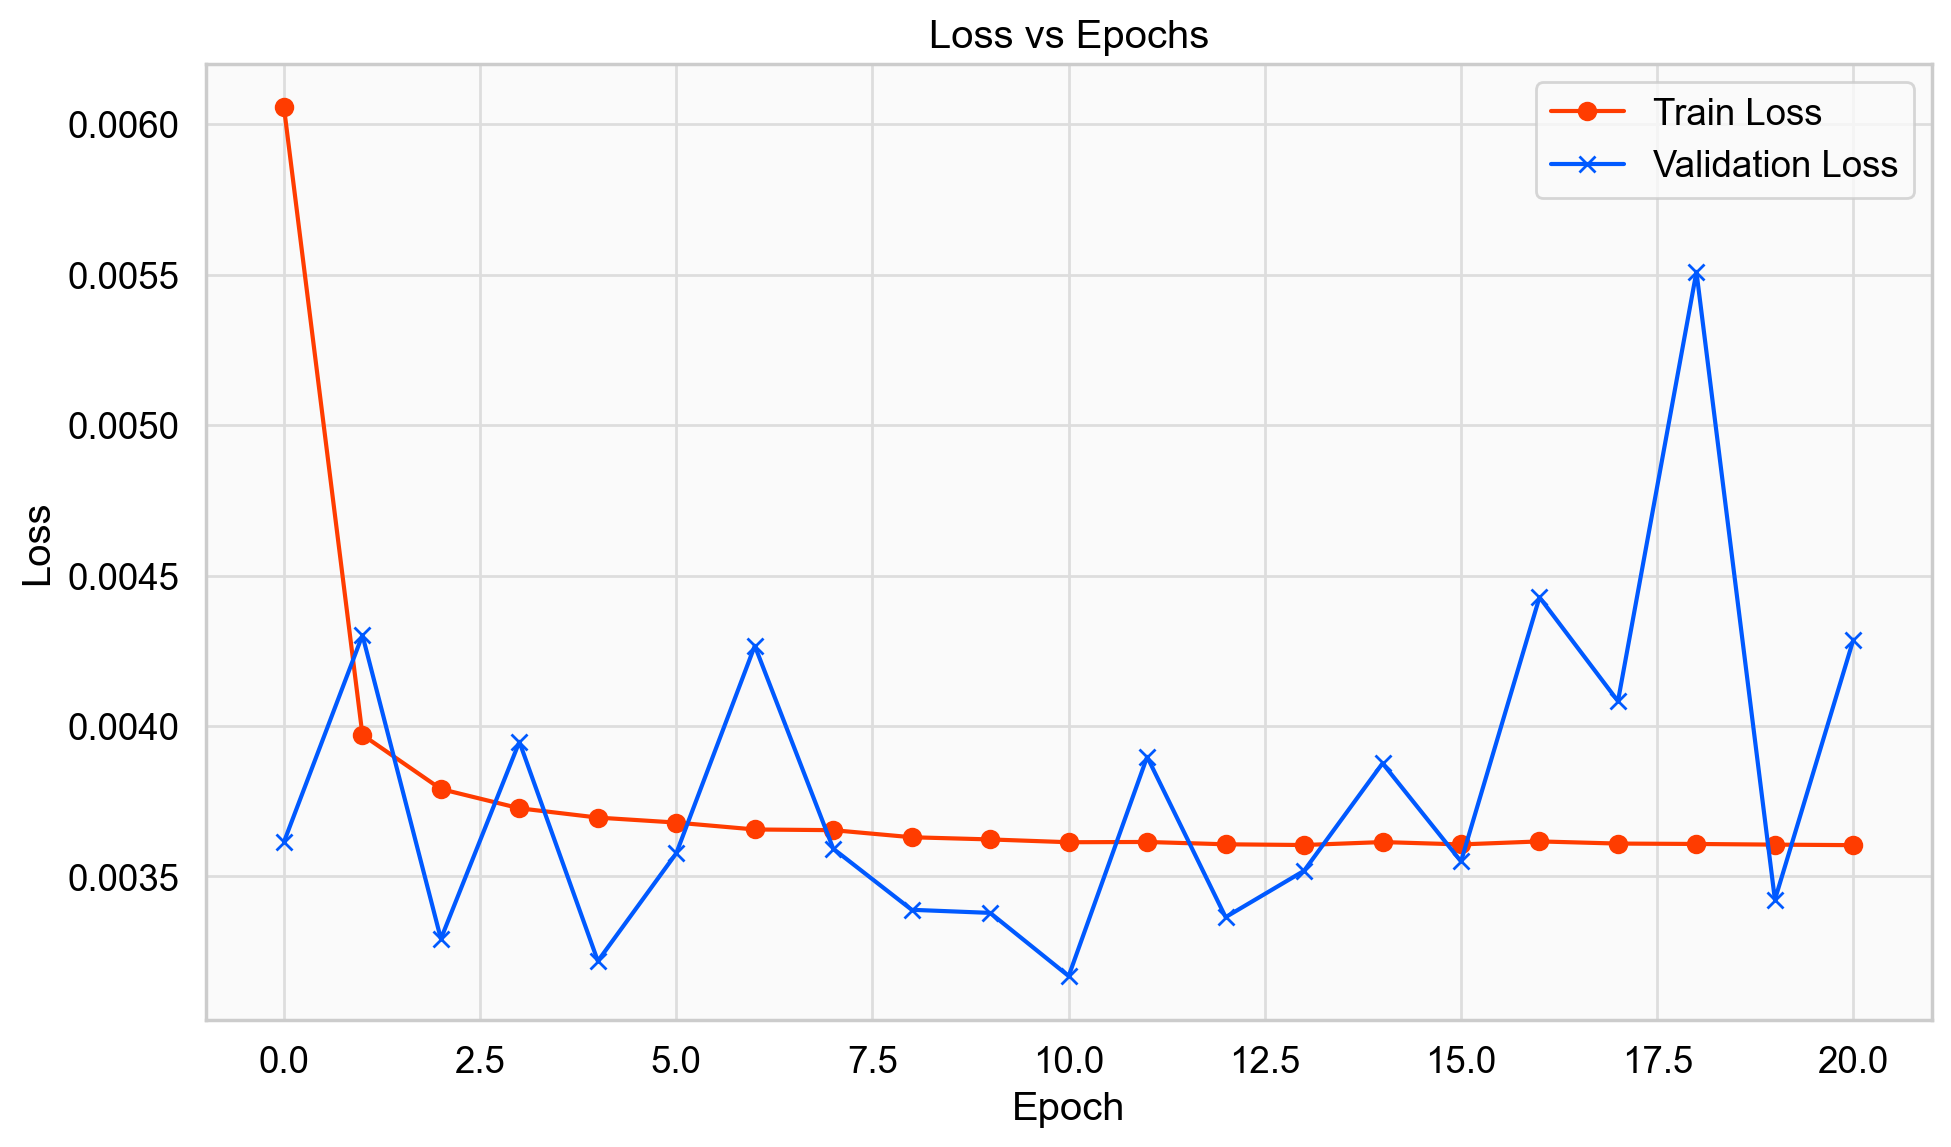

In [96]:
train_model(model, train_loader, val_loader, optimizer, loss_fn, epochs=100, patience=10, path=checkpoint_path)

In [54]:
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()  # Set model to evaluation mode

C:\Users\User\AppData\Local\Temp\ipykernel_24984\1956403801.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)

CNN_1D(
  (block1): Sequential(
    (0): Conv1d(13, 32, kernel_size=(5,), stride=(1,), padding=(2,))
    (1): ReLU()
    (2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
    (4): Dropout(p=0.05, inplace=False)
  )
  (block2): Sequential(
    (0): Conv1d(32, 64, kernel_size=(5,), stride=(1,), padding=(2,))
    (1): ReLU()
    (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
    (4): Dropout(p=0.05, inplace=False)
  )
  (block3): Sequential(
    (0): Conv1d(64, 128, kernel_size=(5,), stride=(1,), padding=(2,))
    (1): ReLU()
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
    (4): Dropout(p=0.05, inplace=False)
  )
  (block4): Sequential(
    (0): Conv1d(128, 256, kernel_size=(5,), stri

In [55]:
evaluate_model(model, test_loader, checkpoint_path, device=device)

C:\Users\User\AppData\Local\Temp\ipykernel_24984\1770941795.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)

Checkpoint loaded from ck_5/CNN_1D_alibaba.pth


Evaluating: 100%|██████████| 10742/10742 [00:11<00:00, 921.83it/s]


##### Evaluation Metrics #####
Test MAE         : 0.0705
Test RMSE        : 0.0879
Test Huber Loss  : 0.0039
Test MSE Loss    : 0.0077
Avg Inference Time per Sample: 0.0074 ms
Total Evaluation Time        : 5.11 seconds


array([[0.071008  , 0.07037902, 0.07501608, 0.08779043, 0.08308578],
       [0.0758847 , 0.07496938, 0.07947809, 0.09185526, 0.08704206],
       [0.07621416, 0.07627761, 0.08125192, 0.09409264, 0.08969095],
       ...,
       [0.28903562, 0.2954933 , 0.30276513, 0.30972806, 0.30914515],
       [0.2600609 , 0.27066743, 0.28026935, 0.29017708, 0.2910089 ],
       [0.2344651 , 0.24858224, 0.26023942, 0.2727077 , 0.27475953]],
      dtype=float32)

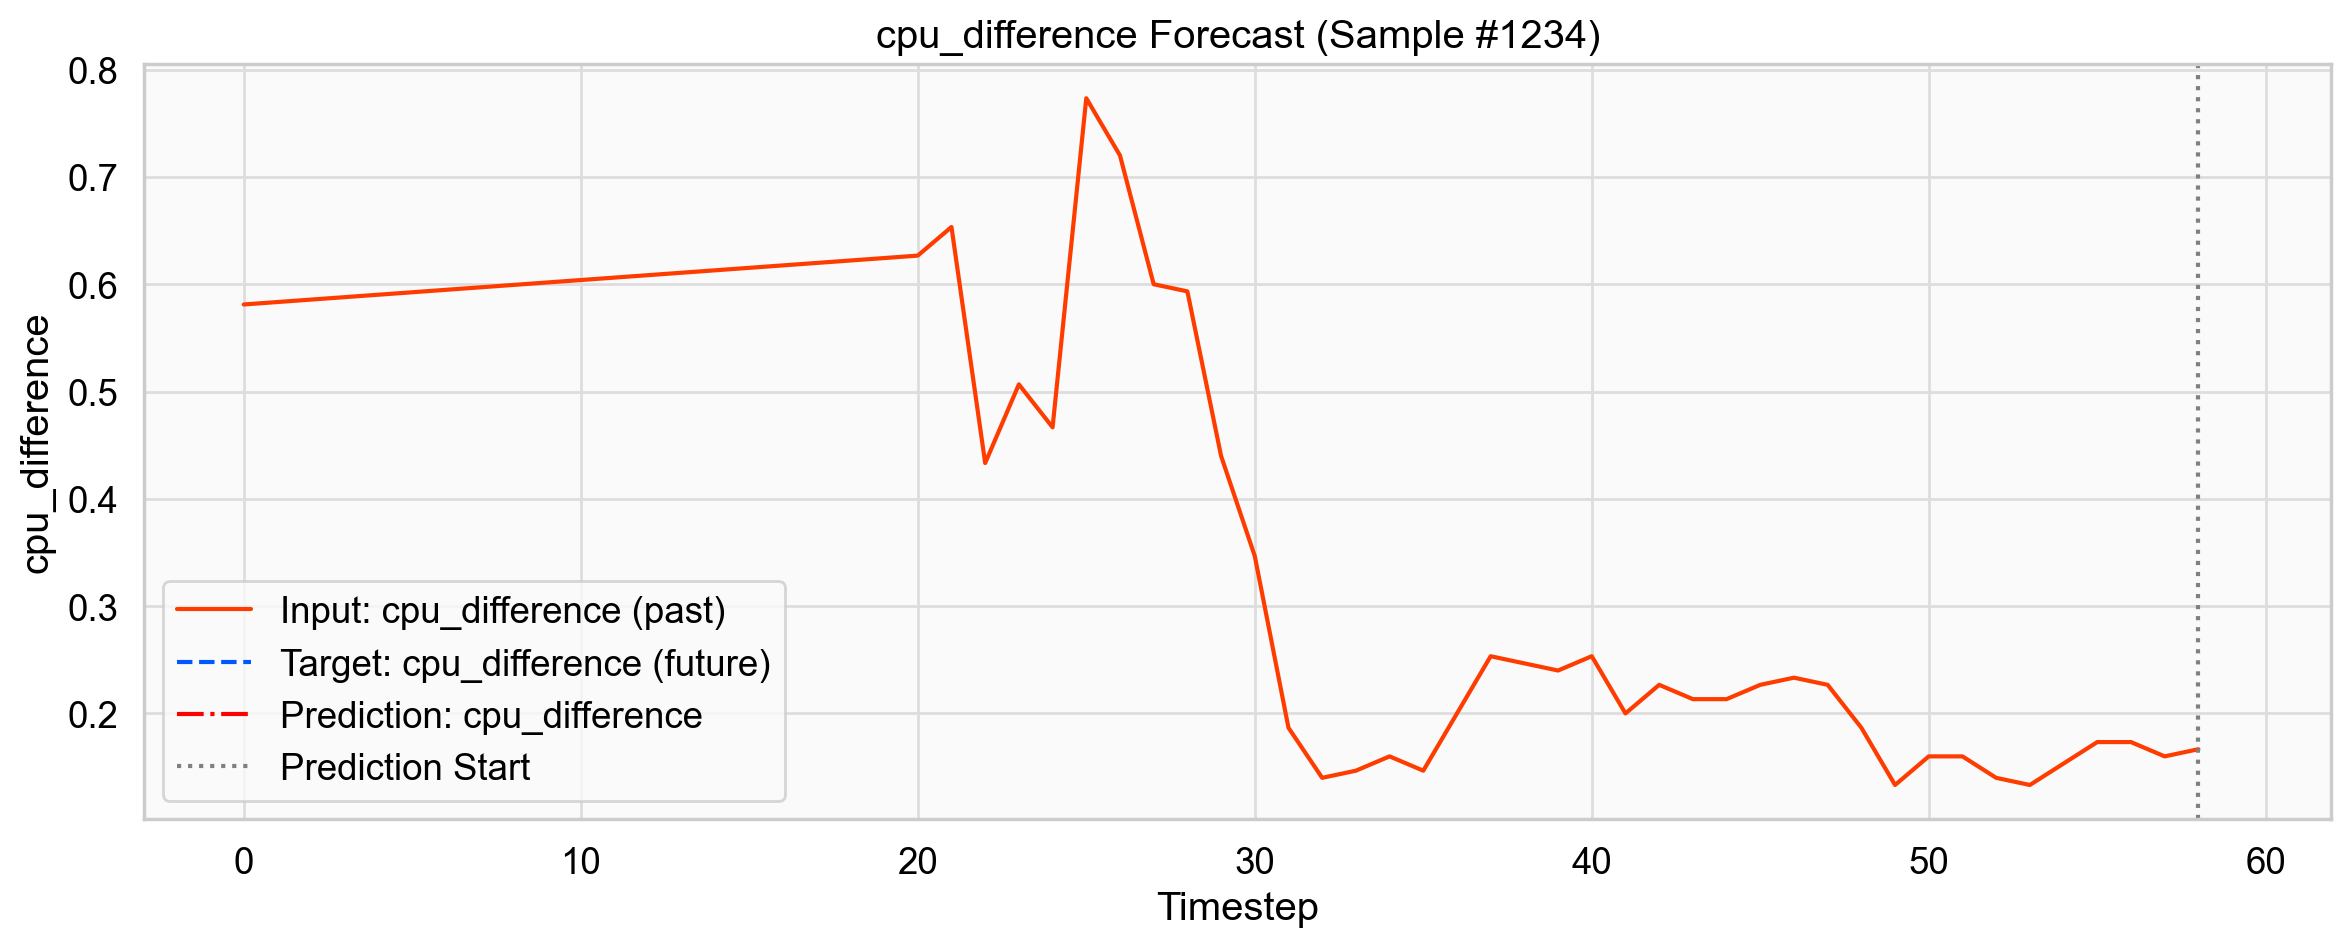

In [99]:
visualize_target_sequence(X_test, y_test, prediction, sample_idx=1234)

#### LSTM DNN

In [56]:
class LSTM_DNN(nn.Module):
    def __init__(self, features):
        super().__init__()
        self.lstm = nn.LSTM(input_size=features, hidden_size=64)
        self.dnn = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=64, out_features=32),
            nn.Tanh(),
            nn.Linear(in_features=32, out_features=forecast_horizon),
        )

    def forward(self, X):
        X = X.permute(1, 0, 2)
        _, (h, _) = self.lstm(X)
        y = self.dnn(h.squeeze(0))
        return y

In [57]:
model = LSTM_DNN(features).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
loss_fn = nn.MSELoss()

print_model_summary(model)

Layer                                    Param Shape                    # Params
--------------------------------------------------------------------------------
lstm.weight_ih_l0                        [256, 13]                      3328
lstm.weight_hh_l0                        [256, 64]                      16384
lstm.bias_ih_l0                          [256]                          256
lstm.bias_hh_l0                          [256]                          256
dnn.1.weight                             [32, 64]                       2048
dnn.1.bias                               [32]                           32
dnn.3.weight                             [5, 32]                        160
dnn.3.bias                               [5]                            5
--------------------------------------------------------------------------------
Total Trainable Params                                                  22,469


In [58]:
checkpoint_path = "ck_5/LSTM_DNN_alibaba.pth"

#### TRAINING STARTED ####


Epoch 1/100: 100%|██████████| 10025/10025 [02:13<00:00, 75.26it/s]


Epoch 01 | Train Loss: 0.0049 | Val Loss: 0.0034
Checkpoint saved at epoch 1


Epoch 2/100: 100%|██████████| 10025/10025 [02:13<00:00, 75.23it/s]


Epoch 02 | Train Loss: 0.0036 | Val Loss: 0.0030
Checkpoint saved at epoch 2
Checkpoint saved at epoch 2


Epoch 3/100: 100%|██████████| 10025/10025 [02:13<00:00, 75.02it/s]


Epoch 03 | Train Loss: 0.0035 | Val Loss: 0.0032


Epoch 4/100: 100%|██████████| 10025/10025 [02:12<00:00, 75.59it/s]


Epoch 04 | Train Loss: 0.0035 | Val Loss: 0.0031
Checkpoint saved at epoch 4


Epoch 5/100: 100%|██████████| 10025/10025 [02:13<00:00, 74.85it/s]


Epoch 05 | Train Loss: 0.0035 | Val Loss: 0.0033


Epoch 6/100: 100%|██████████| 10025/10025 [02:13<00:00, 74.94it/s]


Epoch 06 | Train Loss: 0.0035 | Val Loss: 0.0030
Checkpoint saved at epoch 6


Epoch 7/100: 100%|██████████| 10025/10025 [02:12<00:00, 75.61it/s]


Epoch 07 | Train Loss: 0.0035 | Val Loss: 0.0030


Epoch 8/100: 100%|██████████| 10025/10025 [02:14<00:00, 74.80it/s]


Epoch 08 | Train Loss: 0.0035 | Val Loss: 0.0033
Checkpoint saved at epoch 8


Epoch 9/100: 100%|██████████| 10025/10025 [02:13<00:00, 74.97it/s]


Epoch 09 | Train Loss: 0.0035 | Val Loss: 0.0032


Epoch 10/100: 100%|██████████| 10025/10025 [02:12<00:00, 75.63it/s]


Epoch 10 | Train Loss: 0.0035 | Val Loss: 0.0032
Checkpoint saved at epoch 10


Epoch 11/100: 100%|██████████| 10025/10025 [02:13<00:00, 74.93it/s]


Epoch 11 | Train Loss: 0.0035 | Val Loss: 0.0030
Checkpoint saved at epoch 11


Epoch 12/100: 100%|██████████| 10025/10025 [02:12<00:00, 75.54it/s]


Epoch 12 | Train Loss: 0.0035 | Val Loss: 0.0035
Checkpoint saved at epoch 12


Epoch 13/100: 100%|██████████| 10025/10025 [02:12<00:00, 75.74it/s]


Epoch 13 | Train Loss: 0.0035 | Val Loss: 0.0031


Epoch 14/100: 100%|██████████| 10025/10025 [02:13<00:00, 75.37it/s]


Epoch 14 | Train Loss: 0.0035 | Val Loss: 0.0034
Checkpoint saved at epoch 14


Epoch 15/100: 100%|██████████| 10025/10025 [02:12<00:00, 75.54it/s]


Epoch 15 | Train Loss: 0.0035 | Val Loss: 0.0031


Epoch 16/100: 100%|██████████| 10025/10025 [02:12<00:00, 75.67it/s]


Epoch 16 | Train Loss: 0.0034 | Val Loss: 0.0031
Checkpoint saved at epoch 16


Epoch 17/100: 100%|██████████| 10025/10025 [02:12<00:00, 75.40it/s]


Epoch 17 | Train Loss: 0.0035 | Val Loss: 0.0036


Epoch 18/100: 100%|██████████| 10025/10025 [02:12<00:00, 75.82it/s]


Epoch 18 | Train Loss: 0.0035 | Val Loss: 0.0032
Checkpoint saved at epoch 18


Epoch 19/100: 100%|██████████| 10025/10025 [02:12<00:00, 75.49it/s]


Epoch 19 | Train Loss: 0.0034 | Val Loss: 0.0031


Epoch 20/100: 100%|██████████| 10025/10025 [02:12<00:00, 75.76it/s]


Epoch 20 | Train Loss: 0.0034 | Val Loss: 0.0031
Checkpoint saved at epoch 20


Epoch 21/100: 100%|██████████| 10025/10025 [02:11<00:00, 76.00it/s]


Epoch 21 | Train Loss: 0.0035 | Val Loss: 0.0033
⚠️ Early stopping at epoch 21 (no improvement in val loss for 10 epochs).

#### TRAINING COMPLETE ####
Total Time Elapsed: 3213.58 seconds
Best Validation Loss: 0.0030
Final Train Loss: 0.0035
Final Val Loss: 0.0033


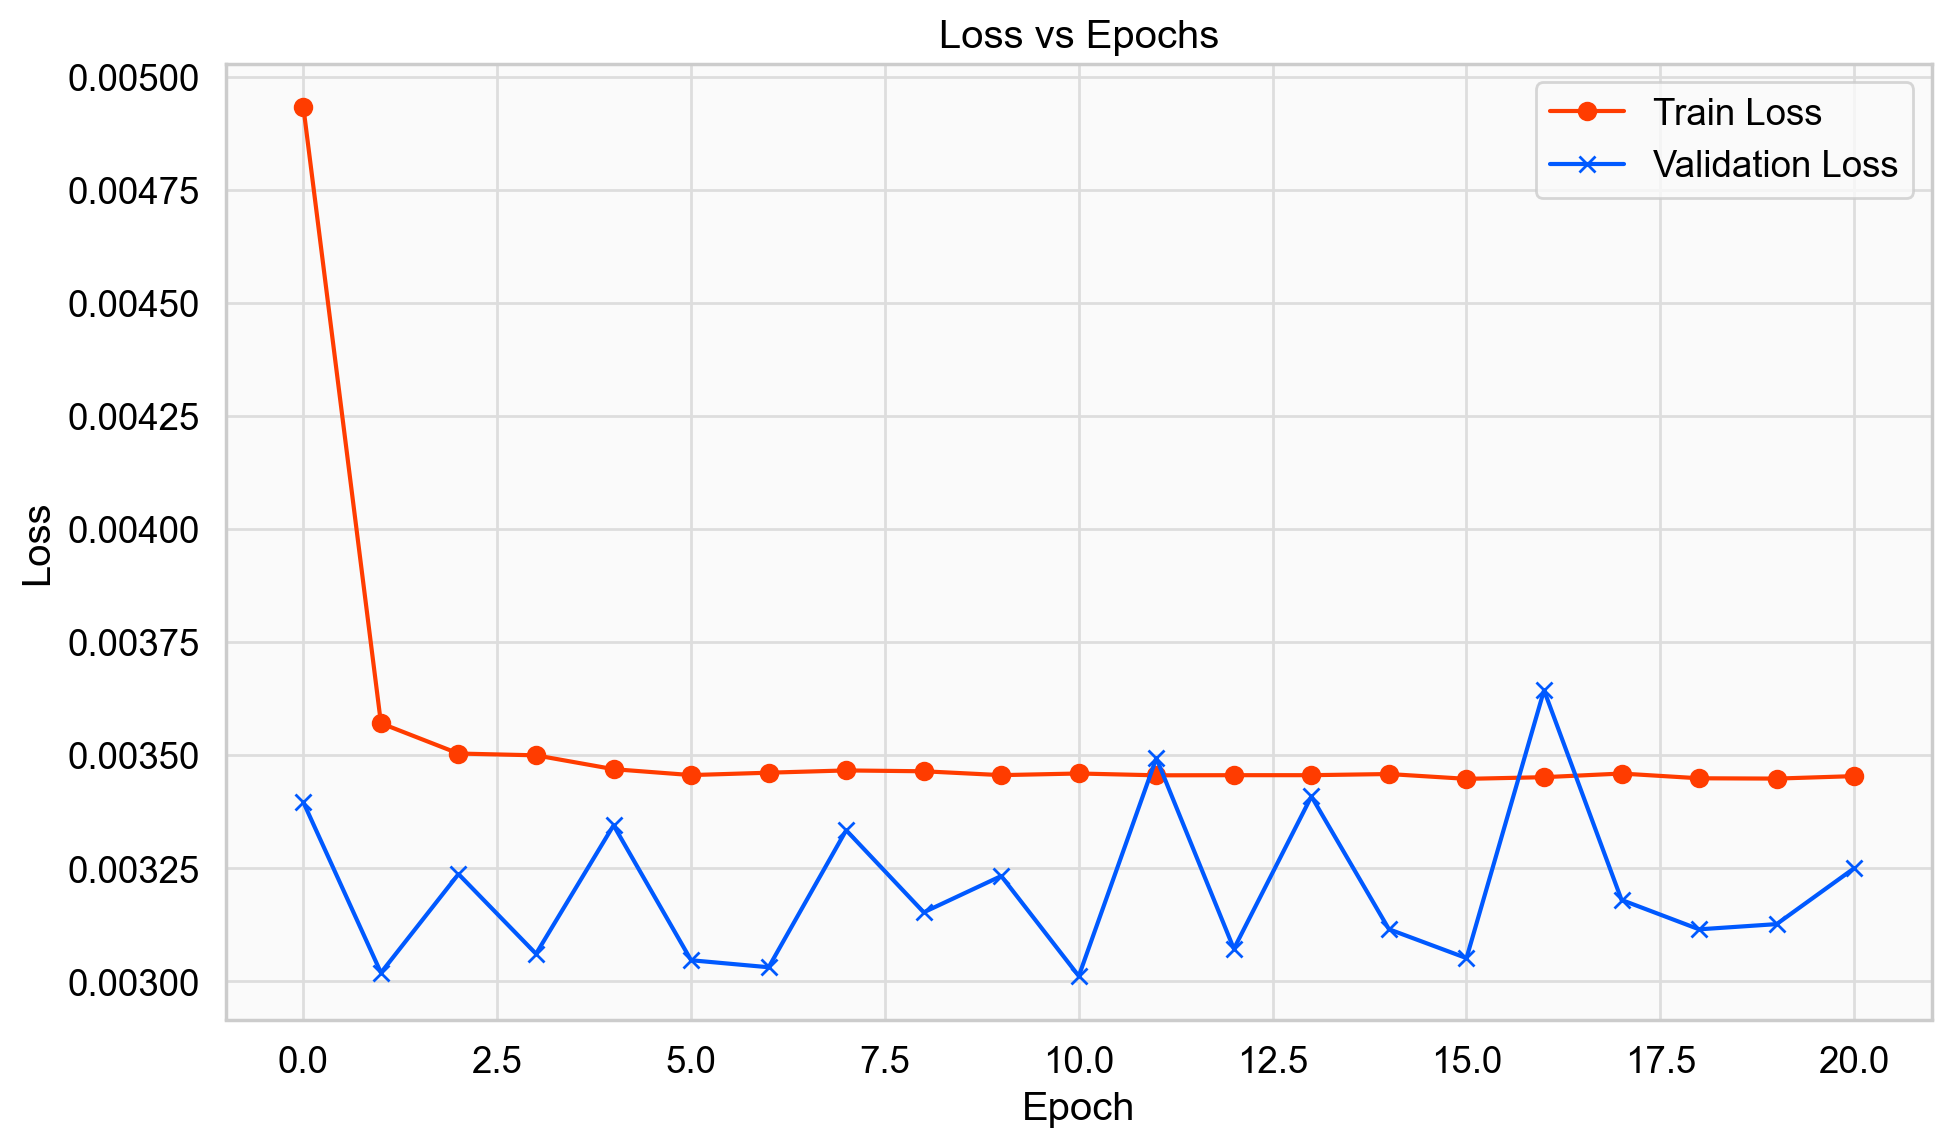

In [103]:
train_model(model, train_loader, val_loader, optimizer, loss_fn, epochs=100, patience=10, path=checkpoint_path)

In [59]:
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()  # Set model to evaluation mode

C:\Users\User\AppData\Local\Temp\ipykernel_24984\1956403801.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)

LSTM_DNN(
  (lstm): LSTM(13, 64)
  (dnn): Sequential(
    (0): Dropout(p=0.2, inplace=False)
    (1): Linear(in_features=64, out_features=32, bias=True)
    (2): Tanh()
    (3): Linear(in_features=32, out_features=5, bias=True)
  )
)

In [60]:
evaluate_model(model, test_loader, checkpoint_path, device=device)

C:\Users\User\AppData\Local\Temp\ipykernel_24984\1770941795.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)

Checkpoint loaded from ck_5/LSTM_DNN_alibaba.pth


Evaluating: 100%|██████████| 10742/10742 [00:10<00:00, 1032.23it/s]


##### Evaluation Metrics #####
Test MAE         : 0.0508
Test RMSE        : 0.0741
Test Huber Loss  : 0.0027
Test MSE Loss    : 0.0055
Avg Inference Time per Sample: 0.0027 ms
Total Evaluation Time        : 1.86 seconds


array([[0.07990679, 0.06946203, 0.06606331, 0.06845602, 0.07799438],
       [0.07849154, 0.06576741, 0.06231225, 0.06908518, 0.07674235],
       [0.0782994 , 0.06914288, 0.07337451, 0.0829297 , 0.07789791],
       ...,
       [0.243298  , 0.25162244, 0.25483546, 0.26496053, 0.27350938],
       [0.25055337, 0.26198372, 0.27479994, 0.28646886, 0.27937037],
       [0.22888342, 0.2462199 , 0.2546968 , 0.25638986, 0.26373038]],
      dtype=float32)

#### TCN

In [64]:
from torch.nn.utils import weight_norm
class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size].contiguous()


class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super(TemporalBlock, self).__init__()
        self.conv1 = weight_norm(nn.Conv1d(n_inputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp1 = Chomp1d(padding)
        self.tanh1 = nn.Tanh()
        self.dropout1 = nn.Dropout(dropout)

        self.net = nn.Sequential(
            self.conv1, self.chomp1, self.tanh1, self.dropout1,
        )
        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.relu = nn.ReLU()
        self.init_weights()

    def init_weights(self):
        self.conv1.weight.data.normal_(0, 0.01)
        if self.downsample is not None:
            self.downsample.weight.data.normal_(0, 0.01)

    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)


class TemporalConvNet(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size=2, dropout=0.2):
        super(TemporalConvNet, self).__init__()
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            layers += [TemporalBlock(in_channels, out_channels, kernel_size, stride=1, dilation=dilation_size,
                                     padding=(kernel_size-1) * dilation_size, dropout=dropout)]

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

class TCN(nn.Module):
    def __init__(self, timesteps, features):
        super(TCN, self).__init__()

        self.tcn = TemporalConvNet(num_inputs=features, num_channels=[8, 16, 32], kernel_size=3)
        self.dnn = nn.Sequential(
            nn.Linear(in_features=timesteps*32, out_features=32),
            nn.Tanh(),
            nn.Linear(in_features=32, out_features=forecast_horizon),
        )

    def forward(self, X):
        X = X.permute(0,2,1)
        H = self.tcn(X)
        y = self.dnn(H.flatten(1))
        return y

In [65]:
# Initialize model and move it to GPU
model = TCN(timesteps, features).to(device)

# Define optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)
loss_fn = nn.MSELoss()

print_model_summary(model)

Layer                                    Param Shape                    # Params
--------------------------------------------------------------------------------
tcn.network.0.conv1.bias                 [8]                            8
tcn.network.0.conv1.weight_g             [8, 1, 1]                      8
tcn.network.0.conv1.weight_v             [8, 13, 3]                     312
tcn.network.0.downsample.weight          [8, 13, 1]                     104
tcn.network.0.downsample.bias            [8]                            8
tcn.network.1.conv1.bias                 [16]                           16
tcn.network.1.conv1.weight_g             [16, 1, 1]                     16
tcn.network.1.conv1.weight_v             [16, 8, 3]                     384
tcn.network.1.downsample.weight          [16, 8, 1]                     128
tcn.network.1.downsample.bias            [16]                           16
tcn.network.2.conv1.bias                 [32]                           32
tcn.network.

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\utils\weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


In [ ]:
checkpoint_path = "ck_1/TCN_model_alibaba.pth"

In [ ]:
train_model(model, train_loader, val_loader, optimizer, loss_fn, epochs=100, patience=10, path=checkpoint_path)

C:\Users\User\AppData\Local\Temp\ipykernel_2752\4142637058.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path, map_location=device)


RuntimeError: Error(s) in loading state_dict for TCN:
	size mismatch for dnn.2.weight: copying a param with shape torch.Size([30, 32]) from checkpoint, the shape in current model is torch.Size([10, 32]).
	size mismatch for dnn.2.bias: copying a param with shape torch.Size([30]) from checkpoint, the shape in current model is torch.Size([10]).

: 

In [ ]:
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()  # Set model to evaluation mode

C:\Users\User\AppData\Local\Temp\ipykernel_9204\1956403801.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


TCN(
  (tcn): TemporalConvNet(
    (network): Sequential(
      (0): TemporalBlock(
        (conv1): Conv1d(13, 8, kernel_size=(3,), stride=(1,), padding=(2,))
        (chomp1): Chomp1d()
        (tanh1): Tanh()
        (dropout1): Dropout(p=0.2, inplace=False)
        (net): Sequential(
          (0): Conv1d(13, 8, kernel_size=(3,), stride=(1,), padding=(2,))
          (1): Chomp1d()
          (2): Tanh()
          (3): Dropout(p=0.2, inplace=False)
        )
        (downsample): Conv1d(13, 8, kernel_size=(1,), stride=(1,))
        (relu): ReLU()
      )
      (1): TemporalBlock(
        (conv1): Conv1d(8, 16, kernel_size=(3,), stride=(1,), padding=(4,), dilation=(2,))
        (chomp1): Chomp1d()
        (tanh1): Tanh()
        (dropout1): Dropout(p=0.2, inplace=False)
        (net): Sequential(
          (0): Conv1d(8, 16, kernel_size=(3,), stride=(1,), padding=(4,), dilation=(2,))
          (1): Chomp1d()
          (2): Tanh()
          (3): Dropout(p=0.2, inplace=False)
        )


In [ ]:
evaluate_model(model, test_loader, checkpoint_path, device=device)

C:\Users\User\AppData\Local\Temp\ipykernel_9204\1770941795.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


Checkpoint loaded from ck/TCN_model_alibaba.pth


Evaluating: 100%|██████████| 2147/2147 [00:02<00:00, 876.74it/s]


ValueError: Input contains NaN.

#### MCDFN

In [17]:
import torch
import torch.nn as nn

class MCDFN(nn.Module):
    def __init__(self, input_shape=(timesteps, features)):
        super(MCDFN, self).__init__()
        self.num_features = input_shape[1]
        
        # CNN Branch
        self.cnn = nn.Sequential(
            nn.Conv1d(in_channels=self.num_features, out_channels=352, kernel_size=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            nn.Flatten(),
            nn.Linear(10208, 128),
            nn.ReLU()
        )
        
        # BiLSTM Branch
        self.bilstm = nn.LSTM(input_size=self.num_features, hidden_size=192, batch_first=True, bidirectional=True)
        self.bilstm_dropout = nn.Dropout(0.2)
        
        # BiGRU Branch
        self.bigru = nn.GRU(input_size=self.num_features, hidden_size=64, batch_first=True, bidirectional=True)
        self.bigru_dropout = nn.Dropout(0.4)
        
        # Multi-Layer LSTM Branch
        self.lstm1 = nn.LSTM(input_size=self.num_features, hidden_size=64, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=64, hidden_size=64, batch_first=True)
        self.lstm_dropout = nn.Dropout(0.2)
        
        # Fully Connected Layer
        self.fc = nn.Sequential(
            nn.Linear(128 + 192 * 2 + 64 * 2 + 64, 30),  # Concatenated features
            nn.Linear(30, forecast_horizon),  # Final output
        )
    
    def forward(self, x):
        # print(f'Before CNN: {x.shape}, {self.num_features}')
        x_cnn = self.cnn(x.permute(0, 2, 1))  # (batch, num_features, time_steps)
        # print(f'After CNN: {x_cnn.shape}')
        
        x_bilstm, _ = self.bilstm(x)
        x_bilstm = self.bilstm_dropout(x_bilstm[:, -1, :])
        
        x_bigru, _ = self.bigru(x)
        x_bigru = self.bigru_dropout(x_bigru[:, -1, :])
        
        x_lstm1, _ = self.lstm1(x)
        x_lstm2, _ = self.lstm2(x_lstm1)
        x_lstm = self.lstm_dropout(x_lstm2[:, -1, :])
        
        x_concat = torch.cat([x_cnn, x_bilstm, x_bigru, x_lstm], dim=1)
        output = self.fc(x_concat)
        return output # Reshape to (batch, 30, 1)

In [18]:

model = MCDFN((timesteps, features)).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
loss_fn = nn.MSELoss()

print_model_summary(model)

Layer                                    Param Shape                    # Params
--------------------------------------------------------------------------------
cnn.0.weight                             [352, 13, 1]                   4576
cnn.0.bias                               [352]                          352
cnn.4.weight                             [128, 10208]                   1306624
cnn.4.bias                               [128]                          128
bilstm.weight_ih_l0                      [768, 13]                      9984
bilstm.weight_hh_l0                      [768, 192]                     147456
bilstm.bias_ih_l0                        [768]                          768
bilstm.bias_hh_l0                        [768]                          768
bilstm.weight_ih_l0_reverse              [768, 13]                      9984
bilstm.weight_hh_l0_reverse              [768, 192]                     147456
bilstm.bias_ih_l0_reverse                [768]                   

In [19]:
checkpoint_path = "ck_1/MCDFN_alibaba.pth"

In [ ]:
train_model(model, train_loader, val_loader, optimizer, loss_fn, epochs=100, patience=10, path=checkpoint_path)

#### TRAINING STARTED ####


Epoch 1/100: 100%|██████████| 10025/10025 [06:11<00:00, 27.01it/s]


Epoch 01 | Train Loss: 0.0991 | Val Loss: 0.0039
Checkpoint saved at epoch 1


Epoch 2/100: 100%|██████████| 10025/10025 [06:07<00:00, 27.25it/s]


Epoch 02 | Train Loss: 0.0044 | Val Loss: 0.0033
Checkpoint saved at epoch 2
Checkpoint saved at epoch 2


Epoch 3/100: 100%|██████████| 10025/10025 [06:06<00:00, 27.32it/s]


Epoch 03 | Train Loss: 0.0034 | Val Loss: 0.0033
Checkpoint saved at epoch 3


Epoch 4/100: 100%|██████████| 10025/10025 [06:10<00:00, 27.09it/s]


Epoch 04 | Train Loss: 0.0033 | Val Loss: 0.0031
Checkpoint saved at epoch 4
Checkpoint saved at epoch 4


Epoch 5/100: 100%|██████████| 10025/10025 [06:10<00:00, 27.06it/s]


Epoch 05 | Train Loss: 0.0033 | Val Loss: 0.0034


Epoch 6/100: 100%|██████████| 10025/10025 [06:07<00:00, 27.30it/s]


Epoch 06 | Train Loss: 0.0033 | Val Loss: 0.0032
Checkpoint saved at epoch 6


Epoch 7/100: 100%|██████████| 10025/10025 [06:07<00:00, 27.28it/s]


Epoch 07 | Train Loss: 0.0033 | Val Loss: 0.0030
Checkpoint saved at epoch 7


Epoch 8/100:  94%|█████████▍| 9462/10025 [05:50<00:23, 24.21it/s]

In [20]:
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()  # Set model to evaluation mode
predictions = evaluate_model(model, test_loader, checkpoint_path, device=device)

C:\Users\User\AppData\Local\Temp\ipykernel_25000\140456513.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


Checkpoint loaded from ck_1/MCDFN_alibaba.pth


Evaluating: 100%|██████████| 10742/10742 [01:28<00:00, 121.86it/s]



##### Evaluation Metrics #####
Test MAE         : 0.0362
Test RMSE        : 0.0564
Test Huber Loss  : 0.0016
Test MSE Loss    : 0.0032
Avg Inference Time per Sample: 0.0113 ms
Total Evaluation Time        : 7.79 seconds


#### SE_LSTM_DNN

In [ ]:
class SE(nn.Module):
    def __init__(self, in_channels, ratio):
        super().__init__()
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),  # squeeze
            nn.Conv2d(in_channels, in_channels//ratio, kernel_size=(1, 1)),  # compress
            nn.ReLU(),
            nn.Conv2d(in_channels//ratio, in_channels, kernel_size=(1, 1)),  # excitation
            nn.Sigmoid(),
        )

    def forward(self, X):
        return self.se(X)

class SENet(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, ratio):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride)
        self.se = SE(out_channels, ratio)
        self.tanh = nn.Tanh()

    def forward(self, X):
        X = self.conv(X)
        coef = self.se(X)
        X = X * coef
        return self.tanh(X)

class SE_LSTM_DNN(nn.Module):
    def __init__(self, learning_rate=0.001, epochs=100, batch_size=50, random_state=0, device='cpu', seq_len=60, sub_seq_len=30):
        super().__init__()
        # self.model_name = "se_lstm_dnn" if sub_seq_len == 30 else "se_lstm_dnn_%d" % sub_seq_len

        self.input_size = int((int(sub_seq_len/2)+1)/4)
        self.senet = SENet(1, 16, (1, 4), (1, 4), 4)
        self.lstm = nn.LSTM(input_size=48, hidden_size=64)
        self.dnn = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=64, out_features=32),
            nn.Tanh(),
            nn.Linear(in_features=32, out_features=forecast_horizon),
        )

    def forward(self, X):
        X = X.unsqueeze(1)
        X = self.senet(X)
        H = X.permute(2, 0, 1, 3).flatten(2)
        _, (h, _) = self.lstm(H)
        y = self.dnn(h.squeeze(0))
        return y


In [ ]:
model = SE_LSTM_DNN().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
loss_fn = nn.MSELoss()

print_model_summary(model)

Layer                                    Param Shape                    # Params
--------------------------------------------------------------------------------
senet.conv.weight                        [16, 1, 1, 4]                  64
senet.conv.bias                          [16]                           16
senet.se.se.1.weight                     [4, 16, 1, 1]                  64
senet.se.se.1.bias                       [4]                            4
senet.se.se.3.weight                     [16, 4, 1, 1]                  64
senet.se.se.3.bias                       [16]                           16
lstm.weight_ih_l0                        [256, 48]                      12288
lstm.weight_hh_l0                        [256, 64]                      16384
lstm.bias_ih_l0                          [256]                          256
lstm.bias_hh_l0                          [256]                          256
dnn.1.weight                             [32, 64]                       2048
dnn.

In [ ]:
checkpoint_path = "ck_1/SE_LSTM_DNN_alibaba.pth"

#### TRAINING STARTED ####


Epoch 1/100: 100%|██████████| 10025/10025 [00:25<00:00, 392.36it/s]


Epoch 01 | Train Loss: 0.0119 | Val Loss: 0.0135
Checkpoint saved at epoch 1


Epoch 2/100: 100%|██████████| 10025/10025 [00:25<00:00, 399.57it/s]


Epoch 02 | Train Loss: 0.0096 | Val Loss: 0.0110
Checkpoint saved at epoch 2
Checkpoint saved at epoch 2


Epoch 3/100: 100%|██████████| 10025/10025 [00:24<00:00, 406.29it/s]


Epoch 03 | Train Loss: 0.0090 | Val Loss: 0.0132


Epoch 4/100: 100%|██████████| 10025/10025 [00:25<00:00, 387.80it/s]


Epoch 04 | Train Loss: 0.0086 | Val Loss: 0.0110
Checkpoint saved at epoch 4
Checkpoint saved at epoch 4


Epoch 5/100: 100%|██████████| 10025/10025 [00:25<00:00, 389.27it/s]


Epoch 05 | Train Loss: 0.0085 | Val Loss: 0.0115


Epoch 6/100: 100%|██████████| 10025/10025 [00:25<00:00, 395.32it/s]


Epoch 06 | Train Loss: 0.0082 | Val Loss: 0.0109
Checkpoint saved at epoch 6
Checkpoint saved at epoch 6


Epoch 7/100: 100%|██████████| 10025/10025 [00:25<00:00, 400.20it/s]


Epoch 07 | Train Loss: 0.0082 | Val Loss: 0.0110


Epoch 8/100: 100%|██████████| 10025/10025 [00:25<00:00, 391.76it/s]


Epoch 08 | Train Loss: 0.0081 | Val Loss: 0.0123
Checkpoint saved at epoch 8


Epoch 9/100: 100%|██████████| 10025/10025 [00:25<00:00, 393.39it/s]


Epoch 09 | Train Loss: 0.0080 | Val Loss: 0.0127


Epoch 10/100: 100%|██████████| 10025/10025 [00:25<00:00, 390.94it/s]


Epoch 10 | Train Loss: 0.0080 | Val Loss: 0.0117
Checkpoint saved at epoch 10


Epoch 11/100: 100%|██████████| 10025/10025 [00:25<00:00, 396.26it/s]


Epoch 11 | Train Loss: 0.0079 | Val Loss: 0.0114


Epoch 12/100: 100%|██████████| 10025/10025 [00:25<00:00, 388.83it/s]


Epoch 12 | Train Loss: 0.0079 | Val Loss: 0.0126
Checkpoint saved at epoch 12


Epoch 13/100: 100%|██████████| 10025/10025 [00:25<00:00, 395.34it/s]


Epoch 13 | Train Loss: 0.0079 | Val Loss: 0.0118


Epoch 14/100: 100%|██████████| 10025/10025 [00:25<00:00, 389.29it/s]


Epoch 14 | Train Loss: 0.0079 | Val Loss: 0.0123
Checkpoint saved at epoch 14


Epoch 15/100: 100%|██████████| 10025/10025 [00:25<00:00, 395.99it/s]


Epoch 15 | Train Loss: 0.0078 | Val Loss: 0.0119


Epoch 16/100: 100%|██████████| 10025/10025 [00:25<00:00, 391.40it/s]


Epoch 16 | Train Loss: 0.0077 | Val Loss: 0.0117
⚠️ Early stopping at epoch 16 (no improvement in val loss for 10 epochs).

#### TRAINING COMPLETE ####
Total Time Elapsed: 445.21 seconds
Best Validation Loss: 0.0109
Final Train Loss: 0.0077
Final Val Loss: 0.0117


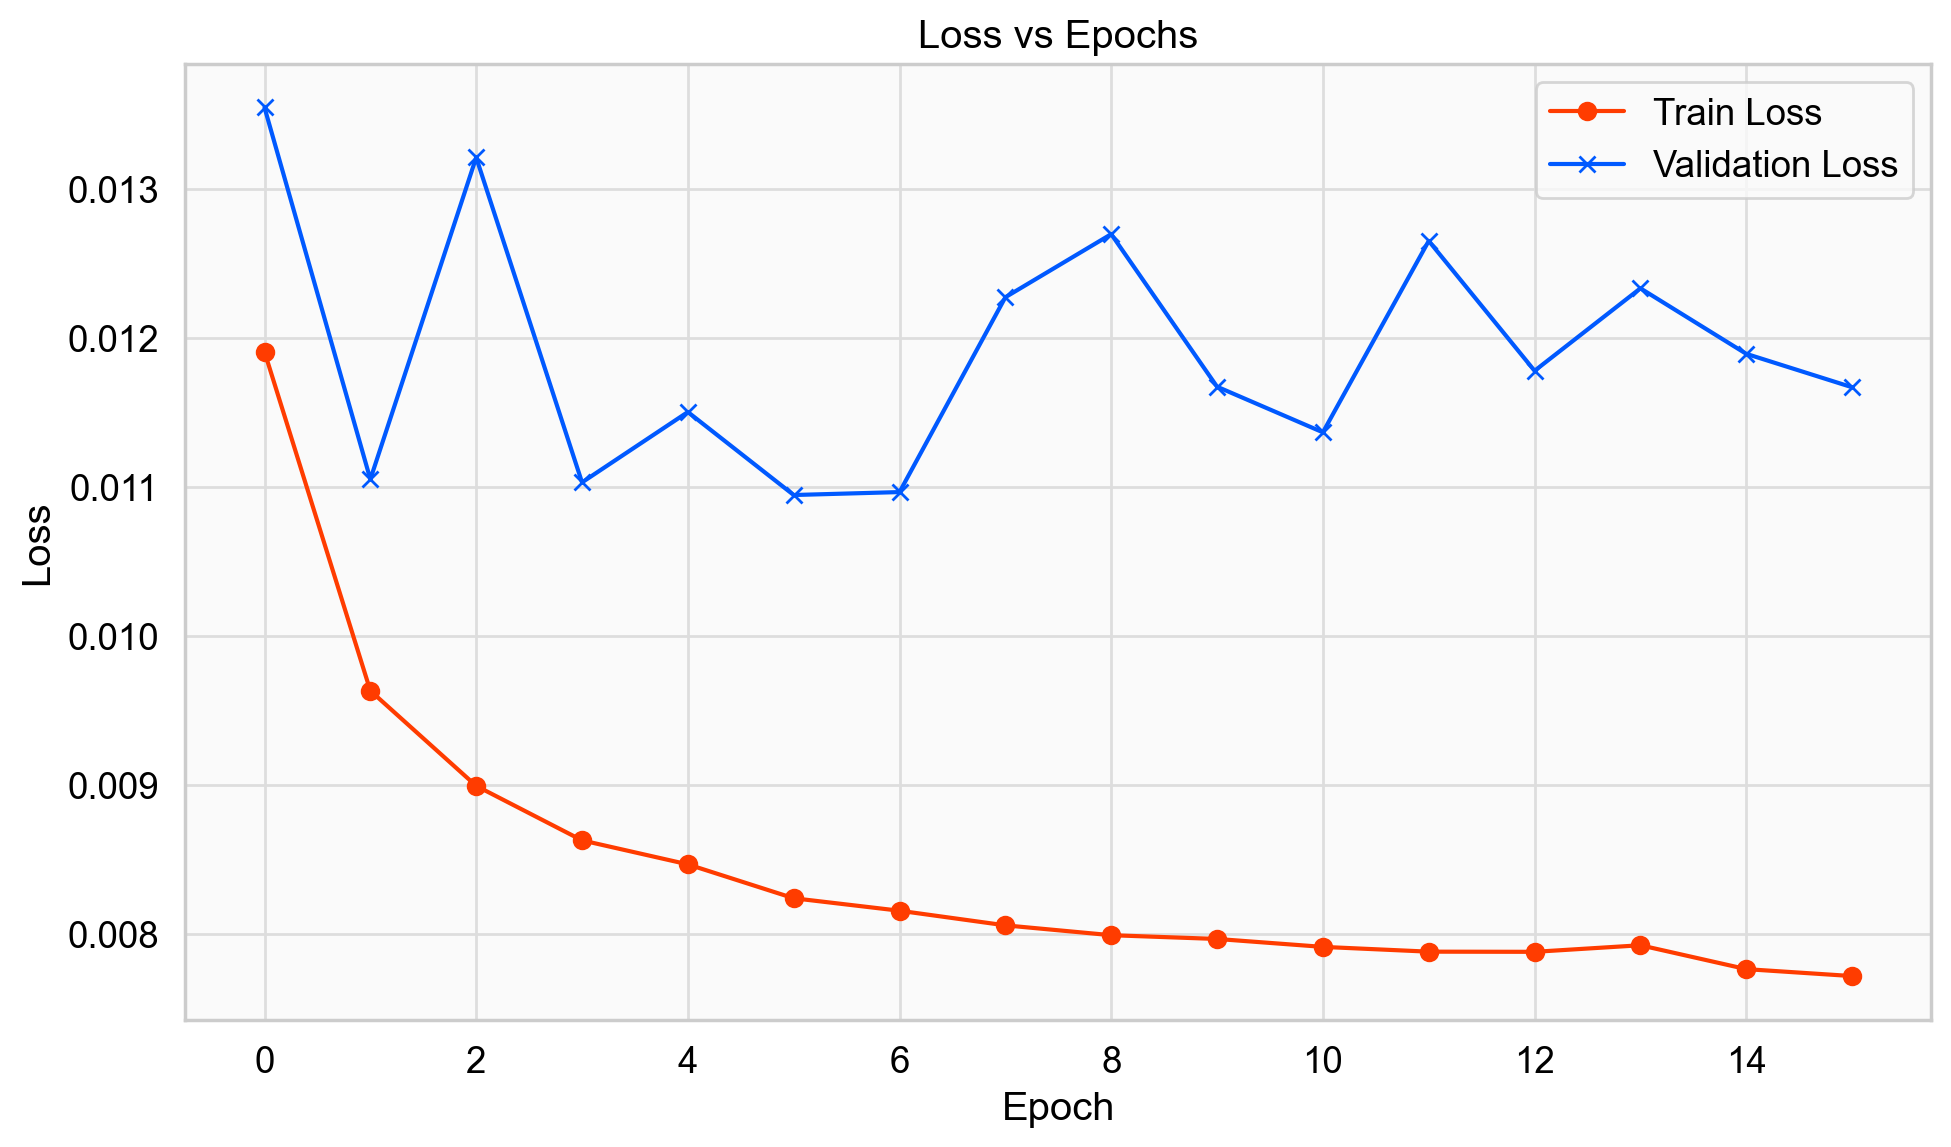

In [ ]:
train_model(model, train_loader, val_loader, optimizer, loss_fn, epochs=100, patience=10, path=checkpoint_path)

In [ ]:
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()  # Set model to evaluation mode
predictions = evaluate_model(model, test_loader, checkpoint_path, device=device)

C:\Users\User\AppData\Local\Temp\ipykernel_3420\140456513.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)
C

Checkpoint loaded from ck_5/SE_LSTM_DNN_alibaba.pth


Evaluating: 100%|██████████| 2147/2147 [00:02<00:00, 855.08it/s]



##### Evaluation Metrics #####
Test MAE         : 0.0853
Test RMSE        : 0.1110
Test Huber Loss  : 0.0062
Test MSE Loss    : 0.0123
Avg Inference Time per Sample: 0.0059 ms
Total Evaluation Time        : 0.81 seconds


#### FreTS

In [22]:
class Model(nn.Module):
    def __init__(self, configs):
        super(Model, self).__init__()
        self.embed_size = 128 #embed_size
        self.hidden_size = 256 #hidden_size
        self.pre_length = configs.pred_len
        self.feature_size = configs.enc_in #channels
        self.seq_length = configs.seq_len
        self.channel_independence = configs.channel_independence
        self.sparsity_threshold = 0.01
        self.scale = 0.02
        self.embeddings = nn.Parameter(torch.randn(1, self.embed_size))
        self.r1 = nn.Parameter(self.scale * torch.randn(self.embed_size, self.embed_size))
        self.i1 = nn.Parameter(self.scale * torch.randn(self.embed_size, self.embed_size))
        self.rb1 = nn.Parameter(self.scale * torch.randn(self.embed_size))
        self.ib1 = nn.Parameter(self.scale * torch.randn(self.embed_size))
        self.r2 = nn.Parameter(self.scale * torch.randn(self.embed_size, self.embed_size))
        self.i2 = nn.Parameter(self.scale * torch.randn(self.embed_size, self.embed_size))
        self.rb2 = nn.Parameter(self.scale * torch.randn(self.embed_size))
        self.ib2 = nn.Parameter(self.scale * torch.randn(self.embed_size))

        self.fc = nn.Sequential(
            nn.Linear(self.seq_length * self.embed_size, self.hidden_size),
            nn.LeakyReLU(),
            nn.Linear(self.hidden_size, self.pre_length)
        )

    # dimension extension
    def tokenEmb(self, x):
        # x: [Batch, Input length, Channel]
        x = x.permute(0, 2, 1)
        x = x.unsqueeze(3)
        # N*T*1 x 1*D = N*T*D
        y = self.embeddings
        return x * y

    # frequency temporal learner
    def MLP_temporal(self, x, B, N, L):
        # [B, N, T, D]
        x = torch.fft.rfft(x, dim=2, norm='ortho') # FFT on L dimension
        y = self.FreMLP(B, N, L, x, self.r2, self.i2, self.rb2, self.ib2)
        x = torch.fft.irfft(y, n=self.seq_length, dim=2, norm="ortho")
        return x

    # frequency channel learner
    def MLP_channel(self, x, B, N, L):
        # [B, N, T, D]
        x = x.permute(0, 2, 1, 3)
        # [B, T, N, D]
        x = torch.fft.rfft(x, dim=2, norm='ortho') # FFT on N dimension
        y = self.FreMLP(B, L, N, x, self.r1, self.i1, self.rb1, self.ib1)
        x = torch.fft.irfft(y, n=self.feature_size, dim=2, norm="ortho")
        x = x.permute(0, 2, 1, 3)
        # [B, N, T, D]
        return x

    # frequency-domain MLPs
    # dimension: FFT along the dimension, r: the real part of weights, i: the imaginary part of weights
    # rb: the real part of bias, ib: the imaginary part of bias
    def FreMLP(self, B, nd, dimension, x, r, i, rb, ib):
        o1_real = torch.zeros([B, nd, dimension // 2 + 1, self.embed_size],
                              device=x.device)
        o1_imag = torch.zeros([B, nd, dimension // 2 + 1, self.embed_size],
                              device=x.device)

        o1_real = F.relu(
            torch.einsum('bijd,dd->bijd', x.real, r) - \
            torch.einsum('bijd,dd->bijd', x.imag, i) + \
            rb
        )

        o1_imag = F.relu(
            torch.einsum('bijd,dd->bijd', x.imag, r) + \
            torch.einsum('bijd,dd->bijd', x.real, i) + \
            ib
        )

        y = torch.stack([o1_real, o1_imag], dim=-1)
        y = F.softshrink(y, lambd=self.sparsity_threshold)
        y = torch.view_as_complex(y)
        return y

    def forward(self, x):
        # x: [Batch, Input length, Channel]
        B, T, N = x.shape
        # embedding x: [B, N, T, D]
        x = self.tokenEmb(x)
        bias = x
        # [B, N, T, D]
        if self.channel_independence == '1':
            x = self.MLP_channel(x, B, N, T)
        # [B, N, T, D]
        x = self.MLP_temporal(x, B, N, T)
        x = x + bias
        x = self.fc(x.reshape(B, N, -1)).permute(0, 2, 1)
        target_feature_idx = -1
        x = x[:, :, target_feature_idx]
        return x

In [23]:
class Configs:
    pred_len = forecast_horizon  # Example long-term prediction length
    enc_in = features  # Number of input features (channels)
    seq_len = timesteps  # Lookback window size (from FEDformer & Autoformer recommendations)
    channel_independence = '1' if pred_len >= 336 else '0'  # Apply channel independence for longer horizons
    embed_size = 128  # Embedding size d
    hidden_size = 256  # Hidden size dh
    batch_size = 32  # Default batch size (can be tuned per dataset)
    learning_rate = 0.001  # Placeholder, needs tuning on validation set


configs = Configs()
model = Model(configs).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
loss_fn = nn.MSELoss()

print_model_summary(model)

Layer                                    Param Shape                    # Params
--------------------------------------------------------------------------------
embeddings                               [1, 128]                       128
r1                                       [128, 128]                     16384
i1                                       [128, 128]                     16384
rb1                                      [128]                          128
ib1                                      [128]                          128
r2                                       [128, 128]                     16384
i2                                       [128, 128]                     16384
rb2                                      [128]                          128
ib2                                      [128]                          128
fc.0.weight                              [256, 7552]                    1933312
fc.0.bias                                [256]                    

In [24]:
checkpoint_path = "ck_1/FreTS_alibaba.pth"

#### TRAINING STARTED ####


Epoch 1/100: 100%|██████████| 10025/10025 [02:27<00:00, 68.15it/s]


Epoch 01 | Train Loss: 0.0116 | Val Loss: 0.0032
Checkpoint saved at epoch 1


Epoch 2/100: 100%|██████████| 10025/10025 [02:25<00:00, 68.86it/s]


Epoch 02 | Train Loss: 0.0033 | Val Loss: 0.0032
Checkpoint saved at epoch 2


Epoch 3/100: 100%|██████████| 10025/10025 [02:25<00:00, 68.74it/s]


Epoch 03 | Train Loss: 0.0032 | Val Loss: 0.0031
Checkpoint saved at epoch 3


Epoch 4/100: 100%|██████████| 10025/10025 [02:25<00:00, 68.77it/s]


Epoch 04 | Train Loss: 0.0032 | Val Loss: 0.0031
Checkpoint saved at epoch 4
Checkpoint saved at epoch 4


Epoch 5/100: 100%|██████████| 10025/10025 [02:25<00:00, 68.76it/s]


Epoch 05 | Train Loss: 0.0032 | Val Loss: 0.0032


Epoch 6/100: 100%|██████████| 10025/10025 [02:25<00:00, 68.76it/s]


Epoch 06 | Train Loss: 0.0032 | Val Loss: 0.0032
Checkpoint saved at epoch 6


Epoch 7/100: 100%|██████████| 10025/10025 [02:25<00:00, 68.77it/s]


Epoch 07 | Train Loss: 0.0032 | Val Loss: 0.0031
Checkpoint saved at epoch 7


Epoch 8/100: 100%|██████████| 10025/10025 [02:25<00:00, 68.79it/s]


Epoch 08 | Train Loss: 0.0032 | Val Loss: 0.0031
Checkpoint saved at epoch 8


Epoch 9/100: 100%|██████████| 10025/10025 [02:25<00:00, 68.80it/s]


Epoch 09 | Train Loss: 0.0032 | Val Loss: 0.0031


Epoch 10/100: 100%|██████████| 10025/10025 [02:25<00:00, 68.80it/s]


Epoch 10 | Train Loss: 0.0032 | Val Loss: 0.0032
Checkpoint saved at epoch 10


Epoch 11/100: 100%|██████████| 10025/10025 [02:25<00:00, 68.75it/s]


Epoch 11 | Train Loss: 0.0032 | Val Loss: 0.0034


Epoch 12/100: 100%|██████████| 10025/10025 [02:25<00:00, 68.77it/s]


Epoch 12 | Train Loss: 0.0031 | Val Loss: 0.0031
Checkpoint saved at epoch 12
Checkpoint saved at epoch 12


Epoch 13/100: 100%|██████████| 10025/10025 [02:25<00:00, 68.77it/s]


Epoch 13 | Train Loss: 0.0031 | Val Loss: 0.0031


Epoch 14/100: 100%|██████████| 10025/10025 [02:25<00:00, 68.80it/s]


Epoch 14 | Train Loss: 0.0031 | Val Loss: 0.0032
Checkpoint saved at epoch 14


Epoch 15/100: 100%|██████████| 10025/10025 [02:25<00:00, 68.79it/s]


Epoch 15 | Train Loss: 0.0031 | Val Loss: 0.0032


Epoch 16/100: 100%|██████████| 10025/10025 [02:25<00:00, 68.81it/s]


Epoch 16 | Train Loss: 0.0031 | Val Loss: 0.0032
Checkpoint saved at epoch 16


Epoch 17/100: 100%|██████████| 10025/10025 [02:25<00:00, 68.76it/s]


Epoch 17 | Train Loss: 0.0031 | Val Loss: 0.0032


Epoch 18/100: 100%|██████████| 10025/10025 [02:25<00:00, 68.77it/s]


Epoch 18 | Train Loss: 0.0031 | Val Loss: 0.0031
Checkpoint saved at epoch 18


Epoch 19/100: 100%|██████████| 10025/10025 [02:25<00:00, 68.77it/s]


Epoch 19 | Train Loss: 0.0031 | Val Loss: 0.0031


Epoch 20/100: 100%|██████████| 10025/10025 [02:25<00:00, 68.80it/s]


Epoch 20 | Train Loss: 0.0031 | Val Loss: 0.0031
Checkpoint saved at epoch 20


Epoch 21/100: 100%|██████████| 10025/10025 [02:25<00:00, 68.79it/s]


Epoch 21 | Train Loss: 0.0031 | Val Loss: 0.0031


Epoch 22/100: 100%|██████████| 10025/10025 [02:25<00:00, 68.79it/s]


Epoch 22 | Train Loss: 0.0031 | Val Loss: 0.0031
⚠️ Early stopping at epoch 22 (no improvement in val loss for 10 epochs).

#### TRAINING COMPLETE ####
Total Time Elapsed: 3453.21 seconds
Best Validation Loss: 0.0031
Final Train Loss: 0.0031
Final Val Loss: 0.0031


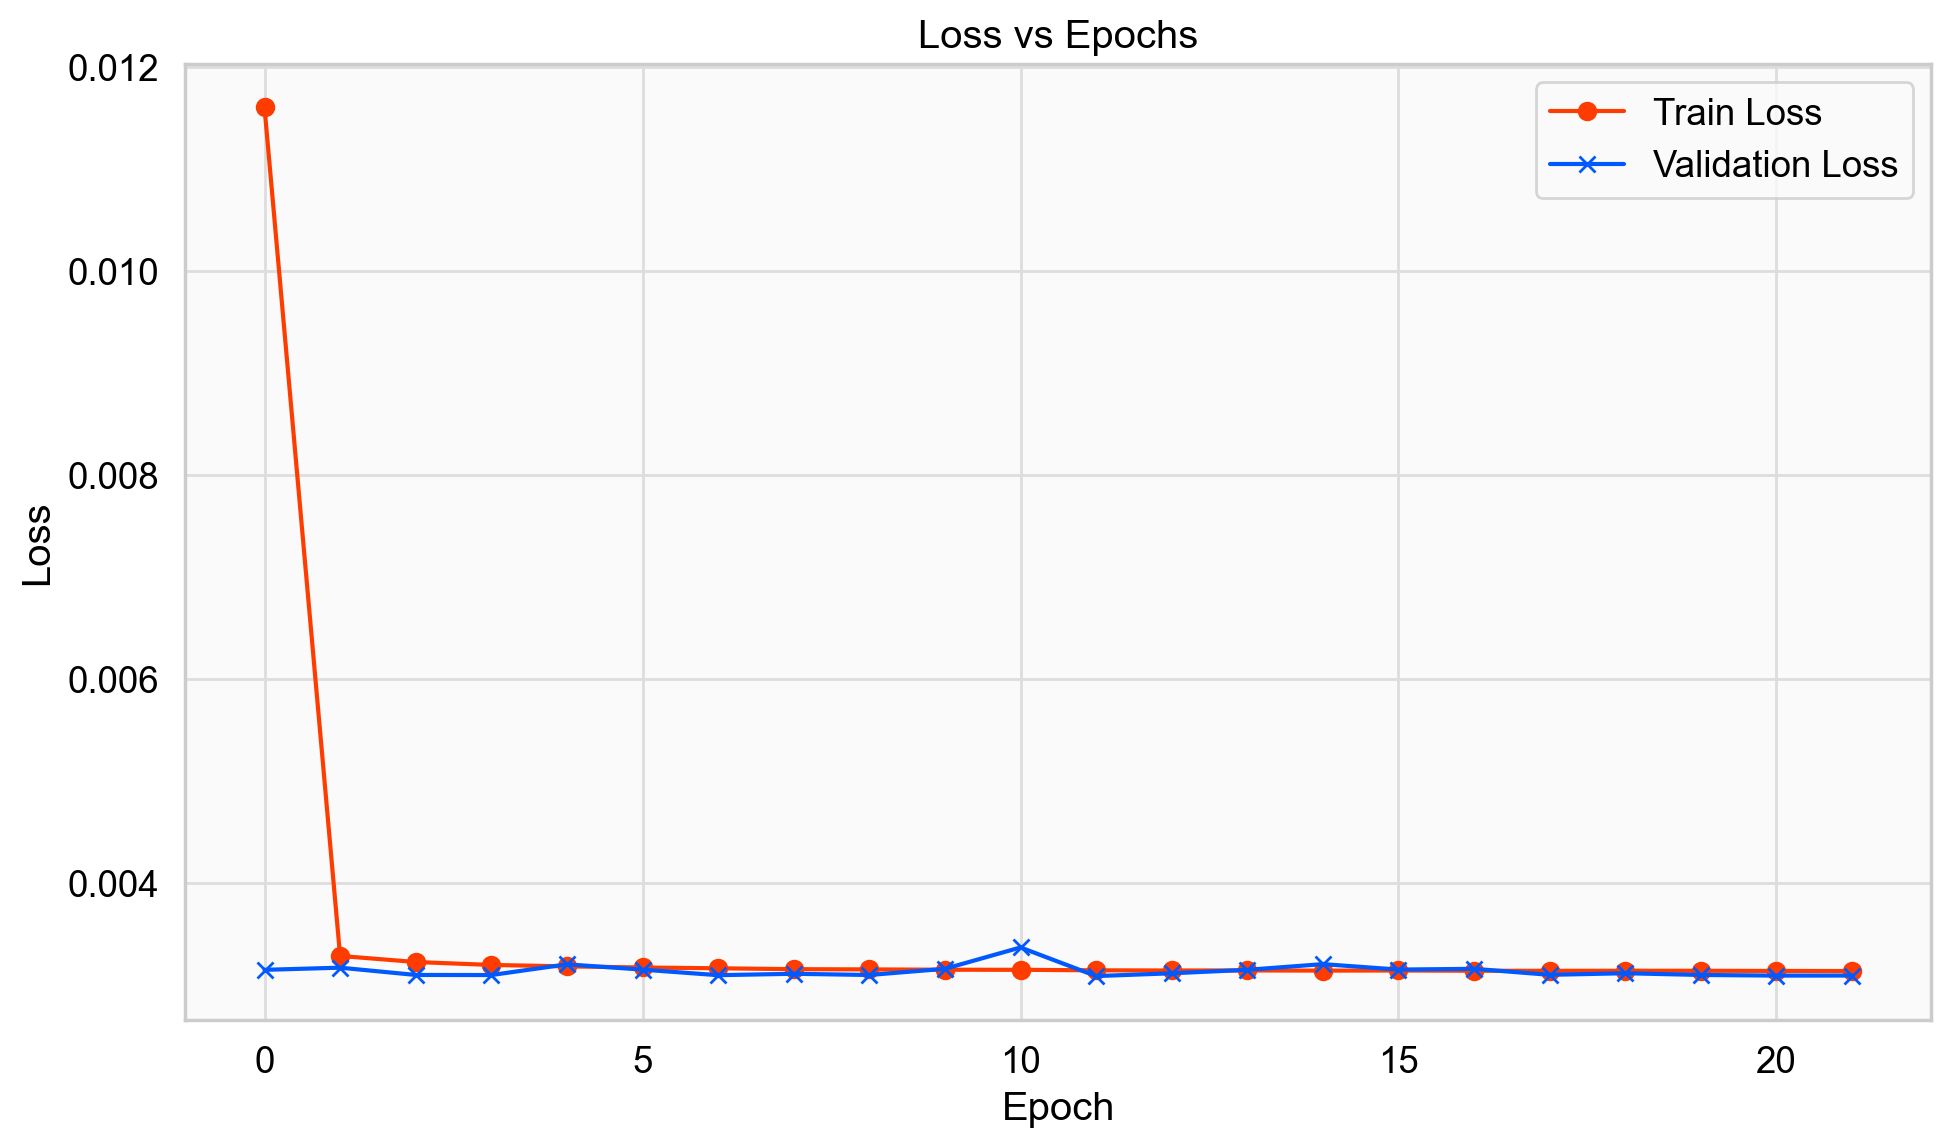

In [25]:
train_model(model, train_loader, val_loader, optimizer, loss_fn, epochs=100, patience=10, path=checkpoint_path)

In [26]:
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()  # Set model to evaluation mode
predictions = evaluate_model(model, test_loader, checkpoint_path, device=device)

Checkpoint loaded from ck_1/FreTS_alibaba.pth

C:\Users\User\AppData\Local\Temp\ipykernel_27312\140456513.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


Evaluating: 100%|██████████| 2147/2147 [00:11<00:00, 188.72it/s]


##### Evaluation Metrics #####
Test MAE         : 0.0370
Test RMSE        : 0.0557
Test Huber Loss  : 0.0016
Test MSE Loss    : 0.0031
Avg Inference Time per Sample: 0.0067 ms
Total Evaluation Time        : 0.92 seconds
